## Install dependencies and load data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime as dt
from wordcloud import WordCloud
from textblob import TextBlob
import ast
import pingouin as pg
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm
from scipy.stats import pearsonr

In [3]:
# Load dataset
fusion = pd.read_csv('/Users/michaeladebayo/Documents/Simplon/brief_projects/movie_prediction/machine_learning/fusionV3_cleaned.csv')

In [4]:
# Convert date columns to datetime objects
for col in ['release_date_france', 'release_date_usa']:
    try:
        fusion[col] = pd.to_datetime(fusion[col], errors='coerce')
    except Exception as e:
        print(f"Error converting column {col}: {e}")

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_28173/4117160534.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fusion[col] = pd.to_datetime(fusion[col], errors='coerce')


In [ ]:
# Display max rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# View first 5 rows in dataframe
fusion.head()

In [6]:
# Filter out rows with missing 'opening_week_france_num' entries
df_fusion = fusion[fusion['opening_week_france_num'] != 0].copy()

## Descriptive analysis

#### Review global stats for numerical columns

In [7]:
df_fusion.describe()

,film_id,year_of_production,release_date_france,release_date_usa,budget,revenue_usa,revenue_world,press_rating,viewer_rating,duration_minutes,producers_count,top_stars_count,languages_count,nationality_list_count,associated_genres_allocine_count,fr_entry_week_iso_week,us_entry_week_iso_week,filming_secrets_num,opening_week_france_num,opening_week_us_num,press_critics_count_num,award_count,nomination_count,total_awards_nomination,viewer_notes,viewer_critiques,trailer_views_num,synopsis_length
count,4980.000000,4980.000000,1971,2520,1.488000e+03,2.485000e+03,4.185000e+03,4977.000000,4977.000000,4971.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4.980000e+03,4.980000e+03,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,4980.000000,442.000000,4980.000000
mean,13222.713454,2012.699799,2013-08-25 20:54:25.753424640,2012-08-06 23:04:34.285714176,5.588693e+07,4.518862e+07,4.136586e+07,3.148081,3.034237,104.076846,1.934337,2.951205,1.240361,0.792369,1.727912,17.730522,7.220080,8.819679,1.825392e+05,6.508010e+06,27.916867,0.659237,2.063454,2.722691,4286.801807,280.827711,45445.857466,364.267671
min,4.000000,2000.000000,2000-01-03 00:00:00,1999-05-14 00:00:00,1.000000e+05,7.400000e+01,8.720000e+02,1.000000,0.800000,26.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.000000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,10177.750000,2007.000000,2007-11-04 00:00:00,2006-09-22 00:00:00,1.500000e+07,3.810520e+05,8.038900e+05,2.700000,2.500000,92.000000,1.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,6.000000,2.171925e+04,0.000000e+00,13.000000,0.000000,0.000000,0.000000,330.000000,47.000000,4857.500000,225.000000
50%,14203.500000,2013.000000,2014-02-04 00:00:00,2012-10-31 00:00:00,3.500000e+07,7.455447e+06,3.931634e+06,3.200000,3.100000,101.000000,2.000000,3.000000,1.000000,0.000000,2.000000,12.000000,0.000000,8.000000,6.323350e+04,0.000000e+00,19.000000,0.000000,0.000000,0.000000,1059.500000,127.000000,17445.500000,340.000000
75%,18993.500000,2018.000000,2019-04-12 00:00:00,2017-11-22 00:00:00,7.500000e+07,4.839019e+07,2.260629e+07,3.600000,3.600000,113.000000,2.000000,3.000000,1.000000,2.000000,2.000000,34.000000,2.000000,11.000000,1.860752e+05,3.162500e+05,24.000000,0.000000,3.000000,3.000000,3205.250000,310.000000,46131.500000,470.250000
max,24570.000000,2025.000000,2025-12-03 00:00:00,2025-10-02 00:00:00,3.560000e+08,9.366622e+08,1.939428e+09,4.900000,4.700000,372.000000,5.000000,3.000000,9.000000,9.000000,7.000000,52.000000,52.000000,58.000000,4.378720e+06,3.571150e+08,6149.000000,54.000000,48.000000,102.000000,206210.000000,7291.000000,721890.000000,1672.000000
std,7467.084573,7.060468,NaN,NaN,5.829215e+07,8.883897e+07,1.177066e+08,0.645960,0.716260,20.194052,0.758897,0.368236,0.670931,1.302223,0.845379,17.684740,14.471078,5.594521,3.410323e+05,2.165772e+07,136.534947,2.010353,4.007122,5.549392,10859.884876,467.727619,85534.472582,205.161983


## Multivariate analysis (general)

#### What year was the most (or least) films produced ?

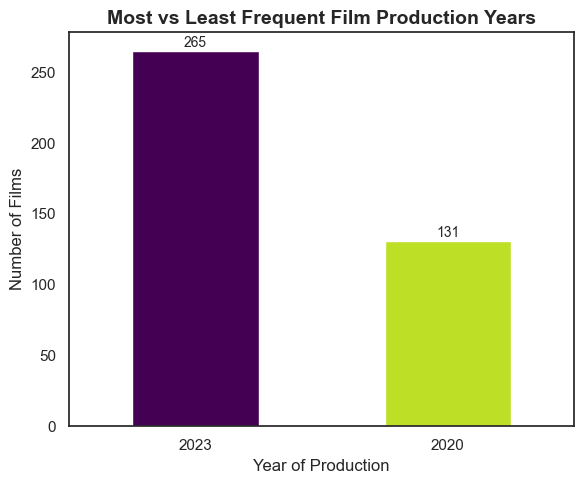

In [8]:
# Get most and least frequent production years
top_production_year = df_fusion['year_of_production'].value_counts().head(1)
least_production_year = df_fusion['year_of_production'].value_counts().nsmallest(2).iloc[1:]

# Combine into one Series for plotting
years_summary = pd.concat([top_production_year, least_production_year])

viridis_colors = [
    '#440154',  # Dark purple
    '#482878',  # Purple
    '#3e4a89',  # Deep blue
    '#31688e',  # Blue
    '#26828e',  # Teal
    '#1f9e89',  # Green-blue
    '#4dbd6e',  # Light green
    '#7ad151',  # Yellow-green
    '#bddf26',  # Yellow
    '#f0f921'   # Bright yellow
]


# Extract colors from the Viridis palette (first and last)
first_color = viridis_colors[0] # First color (darkest)
sixth_color = viridis_colors[-2]  # Sixth color

# Plotting
sns.set_theme(style='white')
plt.figure(figsize=(6, 5))

# Manually set the colors for the bars
ax = years_summary.plot(kind='bar', color=[first_color, sixth_color])

# Title and axis labels
plt.title('Most vs Least Frequent Film Production Years', fontsize=14, fontweight='bold')
plt.xlabel('Year of Production', fontsize=12)
plt.ylabel('Number of Films', fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)

# Remove gridlines
ax.grid(False)

# Annotate bars
for index, value in enumerate(years_summary.values):
    ax.text(index, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


#### What films had the highest/lowest budgets ?

🎬 Film with Max Budget:
             film_title main_genre_jpboxoffice       budget
231  Avengers: Endgame              Comicbook  356000000.0

🎬 Film with Min Budget:
          film_title main_genre_jpboxoffice    budget
323       Le Cercle                  Drame  100000.0
1488  A Ghost Story                  Drame  100000.0


/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_28173/3623526251.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='film_title', y='budget_scaled', data=film_budgets, width=0.5, palette=[viridis_colors[0], viridis_colors[3]])
/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_28173/3623526251.py:28: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='film_title', y='budget_scaled', data=film_budgets, width=0.5, palette=[viridis_colors[0], viridis_colors[3]])


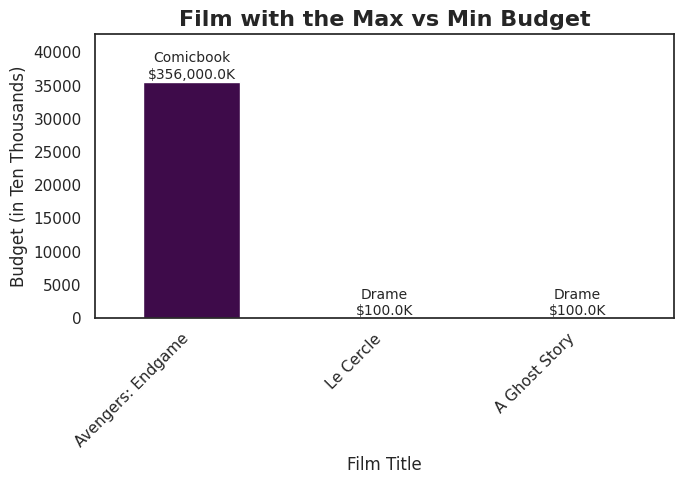

In [9]:
# Film with the overall max budget
film_with_max_budget = df_fusion[df_fusion['budget'] == df_fusion['budget'].max()][['film_title', 'main_genre_jpboxoffice', 'budget']]

# Film with the overall min budget
film_with_min_budget = df_fusion[df_fusion['budget'] == df_fusion['budget'].min()][['film_title', 'main_genre_jpboxoffice', 'budget']]

print("🎬 Film with Max Budget:\n", film_with_max_budget)
print("\n🎬 Film with Min Budget:\n", film_with_min_budget)


# Sample data for the film budgets
film_budgets = pd.DataFrame({
    'film_title': ['Avengers: Endgame', 'Le Cercle', 'A Ghost Story'],
    'main_genre_jpboxoffice': ['Comicbook', 'Drame', 'Drame'],
    'budget': [356000000.0, 100000.0, 100000.0]
})

# Scale the budgets to make them more comparable
film_budgets['budget_scaled'] = film_budgets['budget'] / 10000  # Scale down by 10,000

# Plotting
plt.figure(figsize=(7, 5))

# # Use DejaVu Sans to support emoji if needed
plt.rcParams['font.family'] = 'DejaVu Sans'

# Create a bar plot with viridis palette
sns.barplot(x='film_title', y='budget_scaled', data=film_budgets, width=0.5, palette=[viridis_colors[0], viridis_colors[3]])

# Title and axis labels
plt.title('Film with the Max vs Min Budget', fontsize=16, fontweight='bold')
plt.xlabel('Film Title', fontsize=12)
plt.ylabel('Budget (in Ten Thousands)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

# Adjust y-axis limit to ensure there's space above the bars
plt.ylim(0, film_budgets['budget_scaled'].max() * 1.2)

# Annotate each bar with the genre and budget (in thousands)
for index, row in film_budgets.iterrows():
    # Add a small dynamic offset above each bar for the text
    plt.text(index, row['budget_scaled'] + 0.1, 
             f"{row['main_genre_jpboxoffice']}\n${row['budget'] / 1000:,}K",  # Annotate budget in thousands (K)
             ha='center', va='bottom', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

#### What genres had the highest/lowest budgets ?

💰 Genre with Highest Total Budget: Aventure - Action (21867858000.0)
🪙 Genre with Lowest Total Budget: Court-métrage (14700000.0)


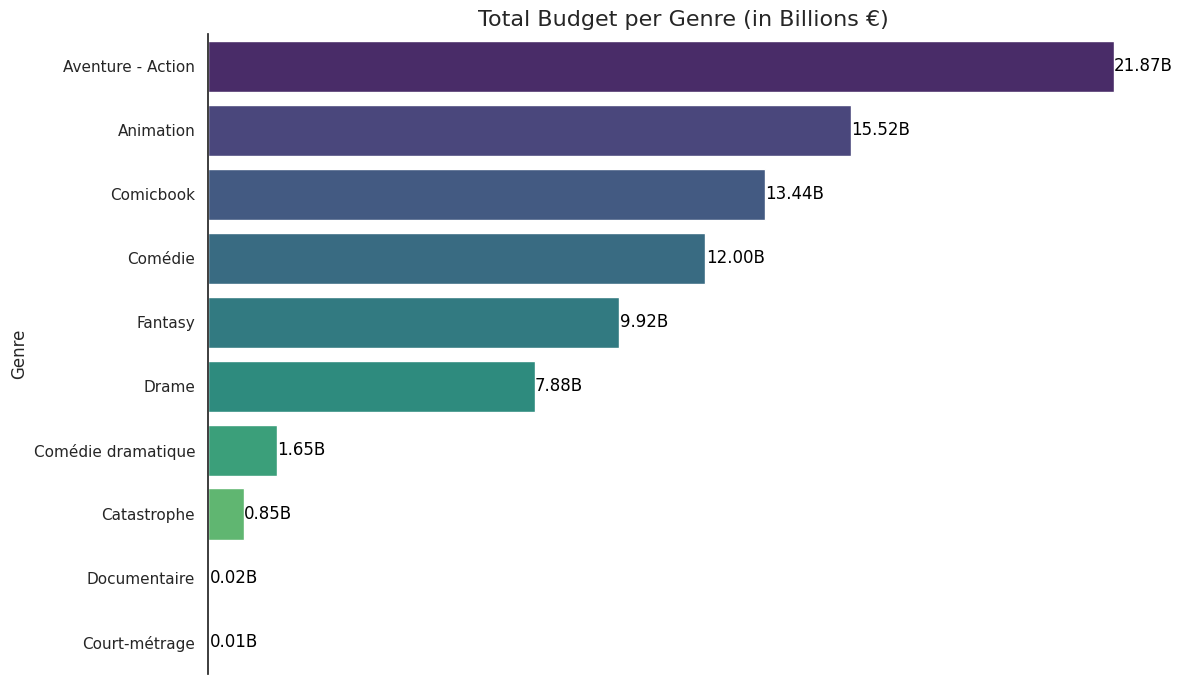

In [10]:
# Total budget per genre
total_budget_per_genre = df_fusion.groupby('main_genre_jpboxoffice')['budget'].sum()

# Genre with the highest total budget
genre_with_highest_total_budget = total_budget_per_genre.idxmax()
highest_total_budget = total_budget_per_genre.max()

# Genre with the lowest total budget
genre_with_lowest_total_budget = total_budget_per_genre.idxmin()
lowest_total_budget = total_budget_per_genre.min()

print(f"💰 Genre with Highest Total Budget: {genre_with_highest_total_budget} ({highest_total_budget})")
print(f"🪙 Genre with Lowest Total Budget: {genre_with_lowest_total_budget} ({lowest_total_budget})")


# Visualize Data

# Prepare the data
total_budget_per_genre_sorted = total_budget_per_genre.sort_values(ascending=False).reset_index()
total_budget_per_genre_sorted.columns = ['Genre', 'Total_Budget']
total_budget_per_genre_sorted['Total_Budget_Billion'] = total_budget_per_genre_sorted['Total_Budget'] / 1e9

# Create the plot
plt.figure(figsize=(12, 7))
barplot = sns.barplot(
    data=total_budget_per_genre_sorted,
    x='Total_Budget_Billion',
    y='Genre',
    palette='viridis', hue='Genre'
)

# Add text labels on bars
for index, row in total_budget_per_genre_sorted.iterrows():
    barplot.text(
        row['Total_Budget_Billion'] + 0.01,
        index,
        f"{row['Total_Budget_Billion']:.2f}B",
        color='black',
        va='center'
    )

# Clean up the x-axis
barplot.set_xlabel('')
barplot.set_xticks([])
barplot.set_xticklabels([])
barplot.tick_params(axis='x', which='both', bottom=False, top=False)

# Optional: remove x-axis line/grid
sns.despine(left=False, bottom=True)

# Final touch
plt.title('Total Budget per Genre (in Billions €)', fontsize=16)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

#### What month was the most(or least) films released in France ?

📈 Most films were released in: August (179 films)
📉 Least films were released in: February (142 films)


/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_28173/2270331040.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=month_counts.index, x=month_counts.values, palette='viridis')


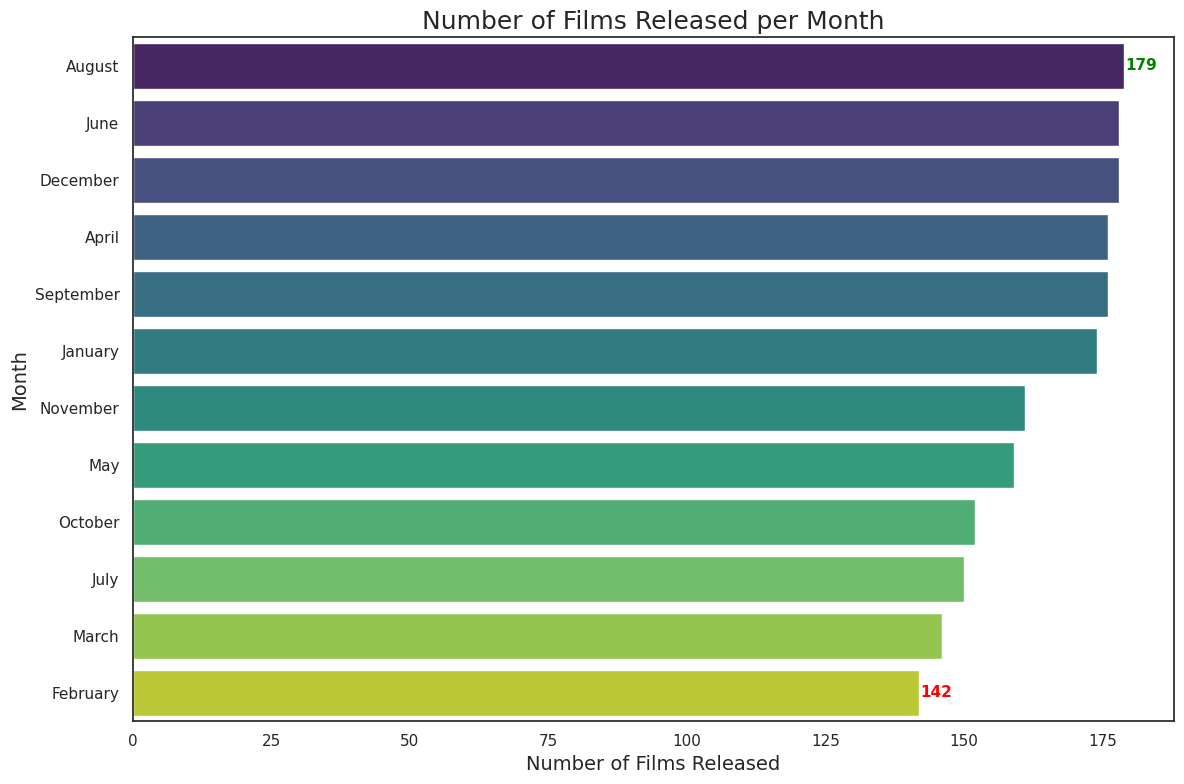

In [11]:
# Convert the release_date column to datetime format (day/month/year)
df_fusion.loc[:, 'release_date_france'] = pd.to_datetime(df_fusion['release_date_france'], format='%d-%m-%Y', errors='coerce')

# Extract the month name from the datetime
df_fusion.loc[:, 'release_month'] = df_fusion['release_date_france'].dt.month_name()

# Count number of films released per month
month_counts = df_fusion['release_month'].value_counts()

# # Get the month with the most and least releases
most_common_month = month_counts.idxmax()
most_common_count = month_counts.max()

least_common_month = month_counts.idxmin()
least_common_count = month_counts.min()

# Print results
print(f"📈 Most films were released in: {most_common_month} ({most_common_count} films)")
print(f"📉 Least films were released in: {least_common_month} ({least_common_count} films)")


## Create plot

# Define custom order for months from January to December
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Get the count of films released per month and ensure the months are ordered
month_counts = df_fusion['release_month'].value_counts().reindex(month_order).fillna(0).sort_values(ascending=False)

# Create a bar plot with months on the Y-axis
plt.figure(figsize=(12, 8))
sns.barplot(y=month_counts.index, x=month_counts.values, palette='viridis')

# Add titles and labels
plt.title('Number of Films Released per Month', fontsize=18)
plt.ylabel('Month', fontsize=14)
plt.xlabel('Number of Films Released', fontsize=14)

# Annotate the months with the most and least releases
plt.text(most_common_count + 0.2, most_common_month, f'{most_common_count}', 
         ha='left', va='center', fontsize=11, color='green', fontweight='bold')
plt.text(least_common_count + 0.2, least_common_month, f'{least_common_count}', 
         ha='left', va='center', fontsize=11, color='red', fontweight='bold')

# Show the plot with a tight layout
plt.tight_layout()
plt.show()


In [12]:
df_fusion.isna().sum()

film_id                                0
film_title                             0
image_url                              0
year_of_production                     0
release_date_france                 3009
release_date_usa                    2460
nationality                         3467
languages                              0
duration                               9
age_classification                  4408
director                               6
top_stars                             72
producers                              6
main_genre_jpboxoffice                 0
associated_genres_allocine             0
synopsis                               3
filming_secrets                        0
awards                              2903
broadcast_category                     0
distributor                          150
budget                              3492
fr_entries                             0
fr_entries_cumul                       0
fr_entry_week                        602
us_entries      

#### What season was the most (or least) films produced ?

+----------------+--------------------------+
| Release Season | Number of Films Released |
+----------------+--------------------------+
|     Autumn     |           1335           |
|     Winter     |           1318           |
|     Spring     |           1212           |
|     Summer     |           1115           |
+----------------+--------------------------+


/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_28173/1227831261.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=release_season_counts.values, y=release_season_counts.index, palette='viridis', width=0.6)


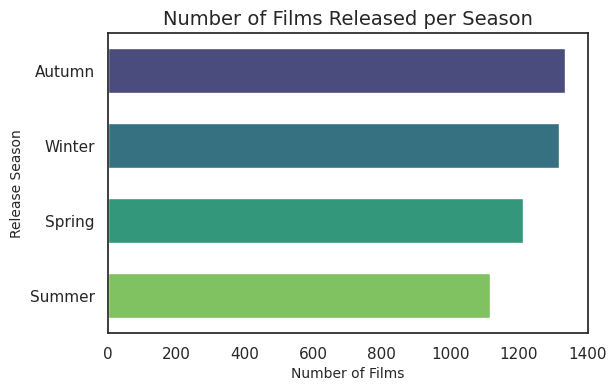

In [13]:
# Get the count of films per release season
release_season_counts = df_fusion['release_season'].value_counts().sort_values(ascending=False)

# Create a PrettyTable instance
table = PrettyTable()

# Define the column names
table.field_names = ["Release Season", "Number of Films Released"]

# Add the data to the table
for season, count in release_season_counts.items():
    table.add_row([season, count])

# Print the table
print(table)


# Create the bar plot with release seasons on the y-axis
plt.figure(figsize=(8, 6))  # Adjust the figure size to avoid large bars
sns.barplot(x=release_season_counts.values, y=release_season_counts.index, palette='viridis', width=0.6)

# Add titles and labels
plt.title('Number of Films Released per Season', fontsize=14)
plt.xlabel('Number of Films', fontsize=10)
plt.ylabel('Release Season', fontsize=10)

# Adjust spacing to reduce gap between labels
plt.tight_layout()  # Ensures the layout is adjusted
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.4)  # Reduce space around the plot

# Show plot
plt.show()


In [14]:
# Funtion to calculate multiple statistics

def multi_stats(df):  # sourcery skip: extract-method, merge-comparisons
    # Top Genres
    top_genres = df['main_genre_jpboxoffice'].value_counts().head(10).reset_index()
    top_genres.columns = ['Genre', 'Count']
    
    # Top actors
    if 'top_stars_list' in df.columns:
        actors_series = df['top_stars_list'].dropna()
        exploded_actors = actors_series.explode()
        top_actors = exploded_actors.value_counts().head(10).to_frame(name='Appearances')
        top_actors.index.name = 'Actor'
        top_actors.reset_index(inplace=True)
        # Remove rows where Actor is an empty list or empty string
        top_actors = top_actors[top_actors['Actor'].apply(lambda x: x != "[]" and x != '')]
    else:
        top_actors = pd.DataFrame(columns=['Actor', 'Appearances'])

    # Average Movie Duration Per Year
    avg_movie_dur = (
        df.groupby('year_of_production')['duration_minutes']
        .mean()
        .reset_index()
        .sort_values(by='year_of_production')
    )
    avg_movie_dur.columns = ['Year', 'Average_Duration_Minutes']

    return top_genres, top_actors, avg_movie_dur

top_genres, top_actors, avg_movie_dur = multi_stats(df_fusion)

#### What genres had the highest number of films ?

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_28173/2995725467.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_genres, x='Count', y='Genre', palette='viridis')


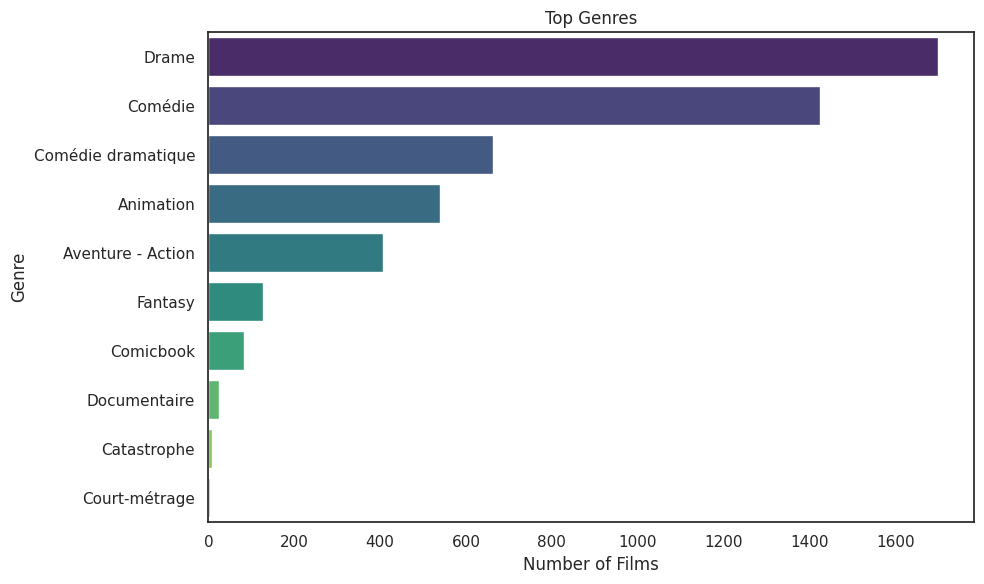

In [15]:
# Plot for Top Genres
plt.figure(figsize=(10, 6))
sns.barplot(data=top_genres, x='Count', y='Genre', palette='viridis')
plt.title('Top Genres')
plt.xlabel('Number of Films')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

#### Which top actors have featured in the most films ?

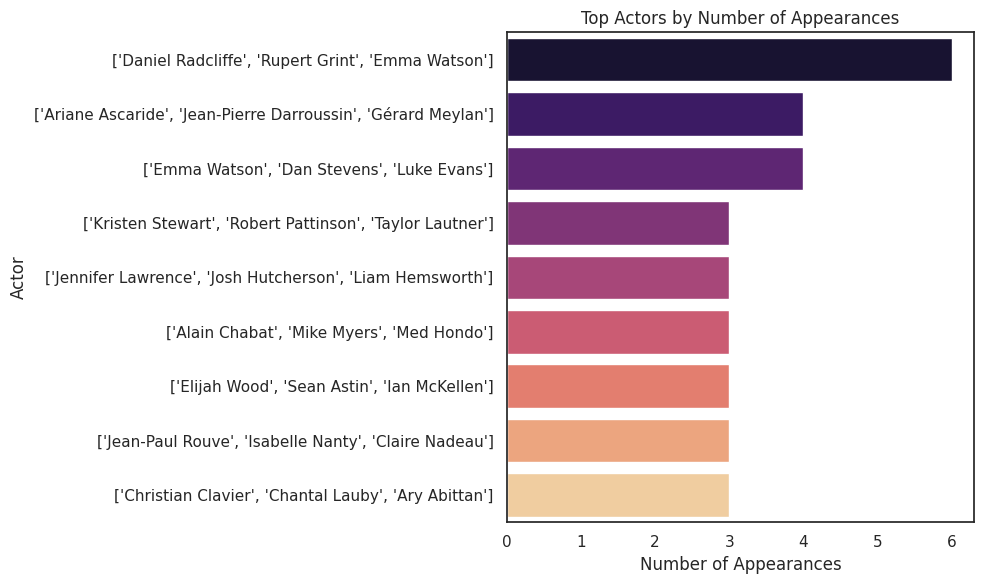

In [16]:
# Plot for Top Actors (if data available)
if not top_actors.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_actors, x='Appearances', y='Actor', palette='magma', hue='Actor')
    plt.title('Top Actors by Number of Appearances')
    plt.xlabel('Number of Appearances')
    plt.ylabel('Actor')
    plt.tight_layout()
    plt.show()
else:
    print("No actor data to display.")


#### What is the average duration (in minutes) per films ?

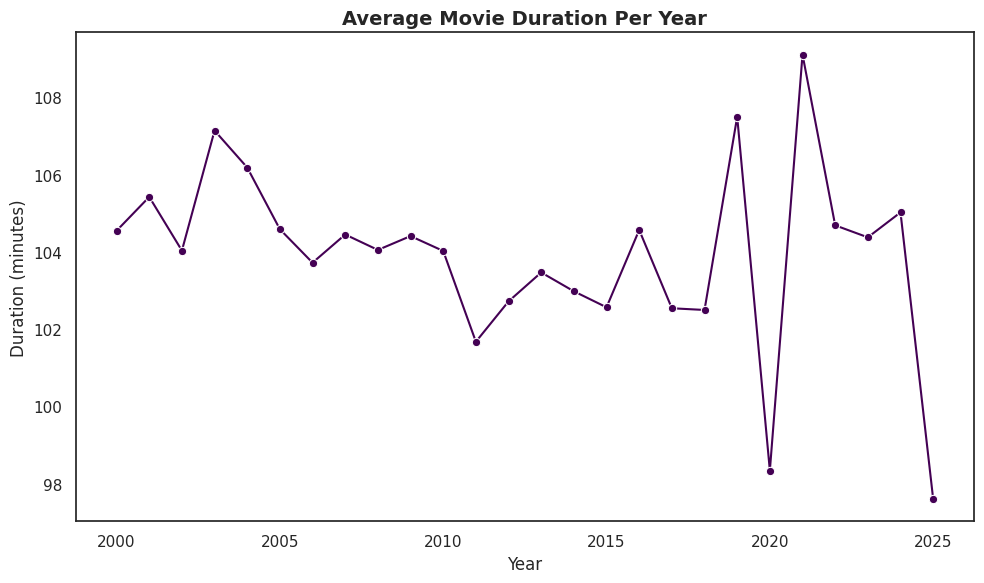

In [17]:
# Plot for Average Movie Duration per Year
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_movie_dur, x='Year', y='Average_Duration_Minutes', marker='o', color=viridis_colors[0])
plt.title('Average Movie Duration Per Year', fontsize=14, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Duration (minutes)', fontsize=12)
plt.tight_layout()
plt.show()

#### What is distribution of the duration (in minutes) of films ?

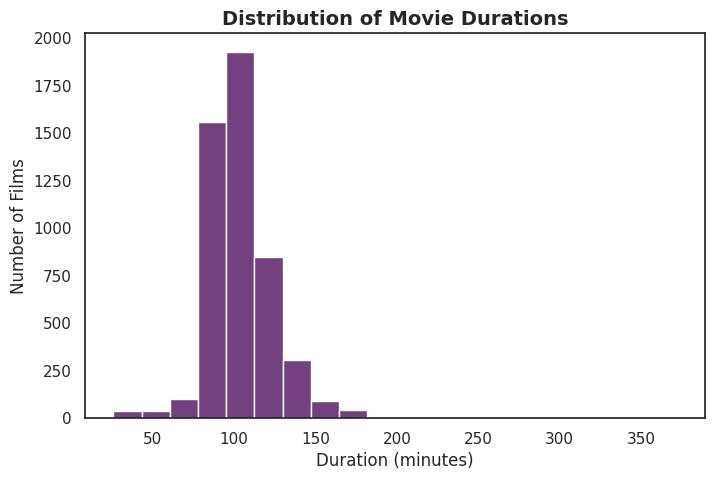

In [18]:
plt.figure(figsize=(8,5))
sns.histplot(df_fusion['duration_minutes'].dropna(), bins=20,color=viridis_colors[0])
plt.title('Distribution of Movie Durations', fontsize=14, fontweight='bold')
plt.xlabel('Duration (minutes)')
plt.ylabel('Number of Films')
plt.show()

In [19]:
df_fusion.columns

Index(['film_id', 'film_title', 'image_url', 'year_of_production',
       'release_date_france', 'release_date_usa', 'nationality', 'languages',
       'duration', 'age_classification', 'director', 'top_stars', 'producers',
       'main_genre_jpboxoffice', 'associated_genres_allocine', 'synopsis',
       'filming_secrets', 'awards', 'broadcast_category', 'distributor',
       'budget', 'fr_entries', 'fr_entries_cumul', 'fr_entry_week',
       'us_entries', 'us_entry_week', 'revenue_usa', 'revenue_world',
       'press_rating', 'viewer_rating', 'press_critics_count',
       'viewer_critics_count', 'trailer_views', 'release_season',
       'duration_minutes', 'producers_list', 'producers_count',
       'top_stars_list', 'top_stars_count', 'languages_list',
       'languages_count', 'nationality_list', 'nationality_list_count',
       'associated_genres_allocine_list', 'associated_genres_allocine_count',
       'fr_entry_week_iso_week', 'us_entry_week_iso_week',
       'filming_secrets_nu

#### Top 10 actor trios with the average global revenue

In [20]:
def actor_success_1(df):
    exploded = df[['top_stars_list', 'revenue_world']].explode('top_stars_list')
    actor_rev = exploded.groupby('top_stars_list')['revenue_world'].mean().sort_values(ascending=False)
    
    print("\n--- Top Revenue-Generating Actors ---")
    actors_suc = actor_rev.head(10).reset_index()
    actors_suc.columns = ['Actor', 'Average_Revenue_World']
    
    return actors_suc


--- Top Revenue-Generating Actors ---
                                               Actor  Average_Revenue_World
0  ['Robert Downey Jr.', 'Chris Evans', 'Mark Ruf...           1.939428e+09
1  ['Robert Downey Jr.', 'Chris Hemsworth', 'Mark...           1.369896e+09
2     ['Vin Diesel', 'Paul Walker', 'Jason Statham']           1.163039e+09
3     ['Daisy Ridley', 'John Boyega', 'Adam Driver']           1.131561e+09
4  ['Rayane Bensetti', 'Donald Glover', 'Anne Sila']           1.113305e+09
5  ['Charlotte Le Bon', 'Amy Poehler', 'Jaynelia ...           1.023200e+09
6  ['Chris Pratt', 'Bryce Dallas Howard', 'Nick R...           1.019443e+09
7  ['Vin Diesel', 'Dwayne Johnson', 'Jason Statham']           1.009997e+09
8  ['Chris Pratt', 'Bryce Dallas Howard', 'Rafe S...           8.917647e+08
9    ['Emmylou Homs', 'Kristen Bell', 'Anaïs Delva']           8.757423e+08


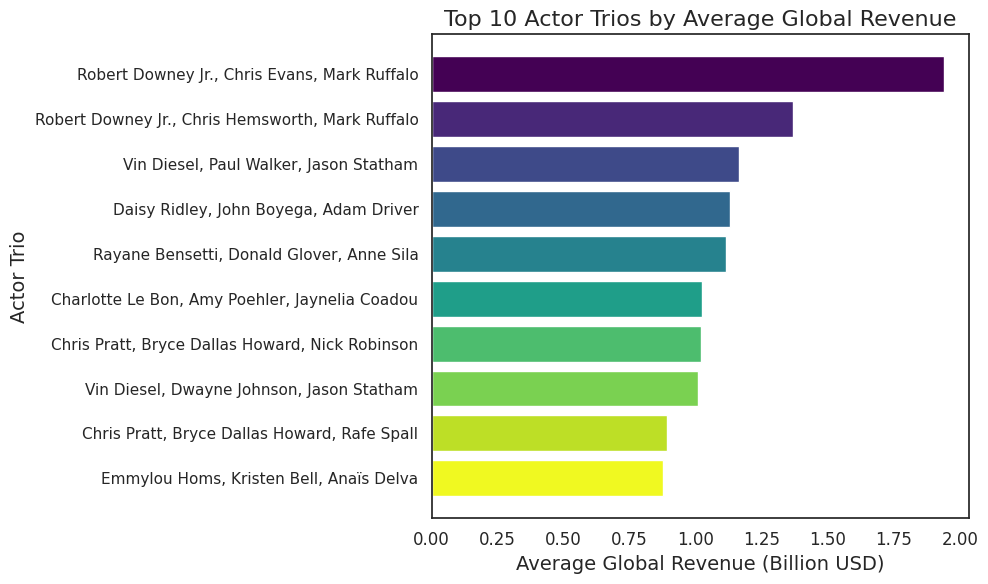

In [21]:
def plot_actor_trio_success(actor_rev_df):
    # Convert stringified lists to actual lists
    actor_rev_df['Actor_Label'] = actor_rev_df['Actor'].apply(
        lambda x: ', '.join(ast.literal_eval(x)) if isinstance(x, str) and x.startswith('[') else str(x)
    )

    # Convert revenue to billions
    actor_rev_df['Revenue_Billion'] = actor_rev_df['Average_Revenue_World'] / 1e9

    # Sort by revenue for barh plot
    plot_df = actor_rev_df.sort_values(by='Revenue_Billion', ascending=True)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(
        plot_df['Actor_Label'],
        plot_df['Revenue_Billion'],
        color=viridis_colors[::-1]
    )
    plt.title('Top 10 Actor Trios by Average Global Revenue', fontsize=16)
    plt.xlabel('Average Global Revenue (Billion USD)', fontsize=14)
    plt.ylabel('Actor Trio', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()


actor_rev_df = actor_success_1(df_fusion)
print(actor_rev_df)
plot_actor_trio_success(actor_rev_df)


#### Top 10 genres by total award count

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_28173/3682871987.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_awards.values, y=genre_awards.index, palette='viridis')


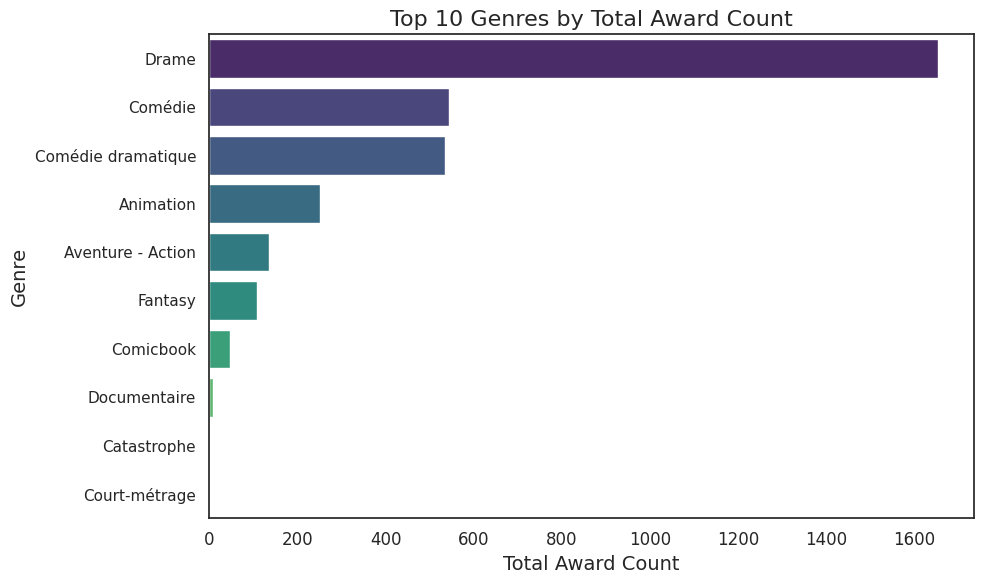

In [22]:
def plot_genre_awards(df):
    # Handle multiple genres per movie
    exploded = df[['main_genre_jpboxoffice', 'award_count']].copy()
    exploded['main_genre_jpboxoffice'] = exploded['main_genre_jpboxoffice'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
    exploded = exploded.explode('main_genre_jpboxoffice')

    # Group by genre and sum awards
    genre_awards = exploded.groupby('main_genre_jpboxoffice')['award_count'].sum().sort_values(ascending=False).head(10)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=genre_awards.values, y=genre_awards.index, palette='viridis')
    plt.title('Top 10 Genres by Total Award Count', fontsize=16)
    plt.xlabel('Total Award Count', fontsize=14)
    plt.ylabel('Genre', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()

plot_genre_awards(df_fusion)

#### Time-series analysis of budget vs global revenue

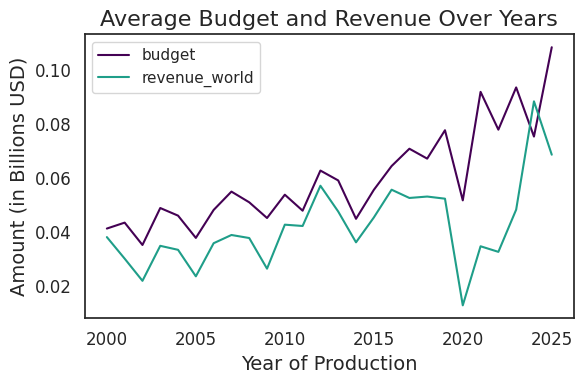

In [23]:
def trend_budget_revenue(df):
    # Group by year and calculate mean
    yearly = df.groupby('year_of_production')[['budget', 'revenue_world']].mean()

    # Convert to billions
    yearly_billion = yearly / 1e9

    # Plot
    plt.figure(figsize=(6, 4))
    yearly_billion.plot(ax=plt.gca(), color=[viridis_colors[0], viridis_colors[5]])
    plt.title("Average Budget and Revenue Over Years", fontsize=16)
    plt.ylabel('Amount (in Billions USD)', fontsize=14)
    plt.xlabel('Year of Production', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

trend_budget_revenue(df_fusion)

#### Text analysis of synopsis (word cloud)

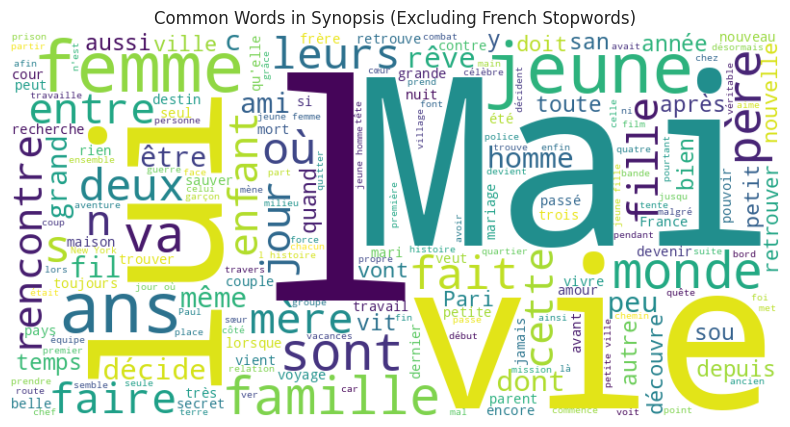

In [24]:
def generate_wordcloud(df):
    # Define French stopwords (you can expand this list if needed)
    french_stopwords = {
        'd',
        'alors',
        'et',
        'est',
        'd\'une',
        'd\'un',
        'la',
        'le',
        'les',
        'des',
        'du',
        'de',
        'un',
        'une',
        'en',
        'dans',
        'que',
        'qui',
        'pour',
        'sur',
        'par',
        'au',
        'aux',
        'ce',
        'ces',
        'son',
        'sa',
        'ses',
        'ne',
        'pas',
        'ou',
        '1',
        'qu',
        'qu\'il',
        'ont',
        'c\'est',
        'plus',
        'avec',
        'il',
        'elle',
        'ils',
        'leur',
        'tout',
        'tous',
        'elles',
        'nous',
        'vous',
        'se',
        'comme',
        'a',
        'à',
        'n\'a',
    }

    # Combine with default stopwords
    custom_stopwords = STOPWORDS.union(french_stopwords)

    text = ' '.join(df['synopsis'].dropna().astype(str).tolist())
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=custom_stopwords
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Common Words in Synopsis (Excluding French Stopwords)")
    plt.show()



generate_wordcloud(df_fusion)

#### Sentiment Analysis of Synopsis

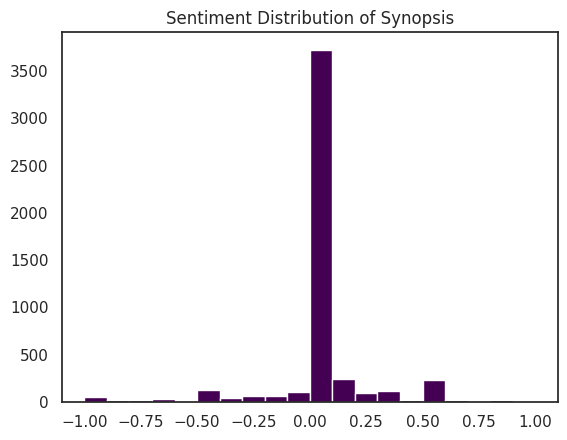

In [25]:
def sentiment_synopsis(df):
    df['synopsis_sentiment'] = df['synopsis'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    plt.hist(df['synopsis_sentiment'], bins=20, color=viridis_colors[0])
    plt.title("Sentiment Distribution of Synopsis")
    plt.show()

sentiment_synopsis(df_fusion)

## Multivariate analysis (France) 

### 🎯 Analysis Business Objective : What factors influence a strong film opening attendance in France?

### 🔍 Audience & Content Fit

#### 🎥 Which genres perform best in opening week? (JpBoxOffice)

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_28173/987282637.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_perf.values, y=genre_perf.index, palette='viridis')


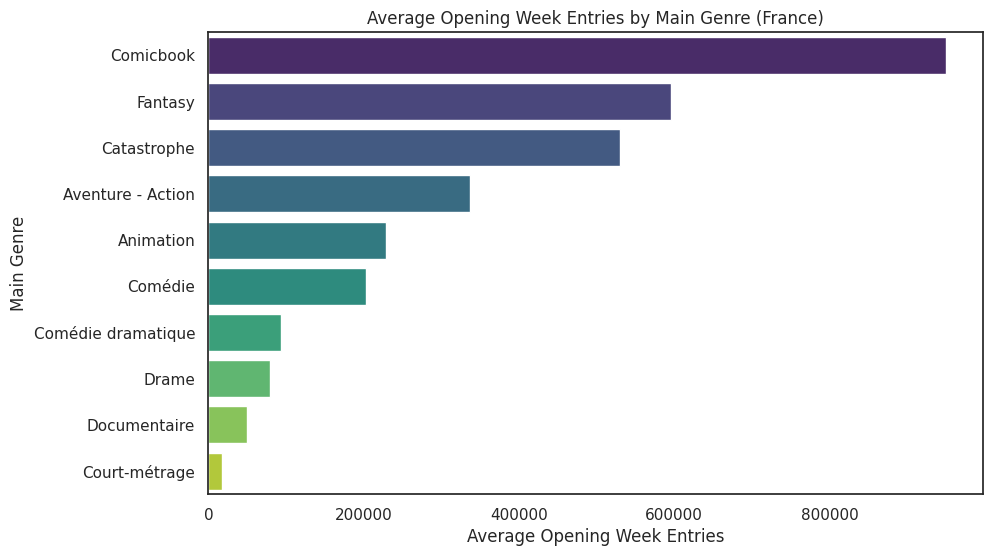

In [26]:
# Group by main genre and calculate average first-week entries
genre_perf = df_fusion.groupby('main_genre_jpboxoffice')['opening_week_france_num'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=genre_perf.values, y=genre_perf.index, palette='viridis')
plt.title('Average Opening Week Entries by Main Genre (France)')
plt.xlabel('Average Opening Week Entries')
plt.ylabel('Main Genre')
plt.show()

#### 🎬 Which film genres attract the largest audiences during opening week in France (Allocine) ?

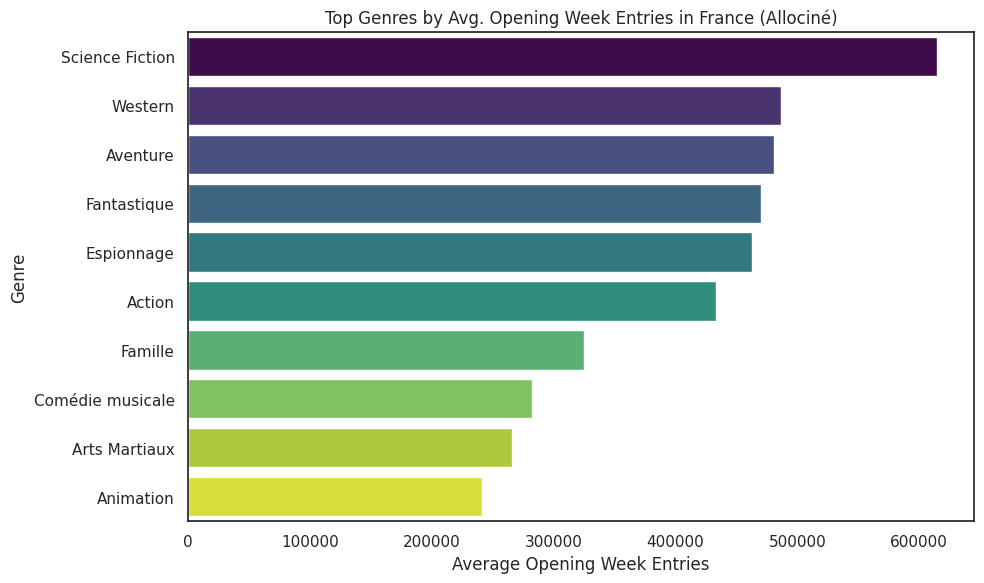

In [27]:
# Convert strings to actual lists if not already
import ast

df_fusion['associated_genres_allocine_list'] = df_fusion['associated_genres_allocine_list'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
)

# Explode the genre list
df_exploded_genres = df_fusion.explode('associated_genres_allocine_list')

# Group and analyze
genre_perf = (
    df_exploded_genres
    .groupby('associated_genres_allocine_list')['opening_week_france_num']
    .agg(['count', 'mean'])
    .reset_index()
    .rename(columns={
        'associated_genres_allocine_list': 'Genre',
        'count': 'Number of Films',
        'mean': 'Average Opening Week Entries'
    })
    .sort_values(by='Average Opening Week Entries', ascending=False)
)

# Plot top 10 performing genres by average opening week entries
plt.figure(figsize=(10, 6))
sns.barplot(
    data=genre_perf.head(10),
    x='Average Opening Week Entries',
    y='Genre',
    palette=viridis_colors,
    hue='Genre',
    legend=False
)
plt.title('Top Genres by Avg. Opening Week Entries in France (Allociné)')
plt.xlabel('Average Opening Week Entries')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

#### 🇫🇷 Do films produced in France or in collaboration with France outperform international ones?

In [28]:
import ast
import contextlib

def safe_parse_list(x):
    with contextlib.suppress(Exception):
        if isinstance(x, str) and x.startswith('['):
            return ast.literal_eval(x)
    return []

# Fix nationality_list
df_fusion['nationality_list'] = df_fusion['nationality_list'].apply(safe_parse_list)

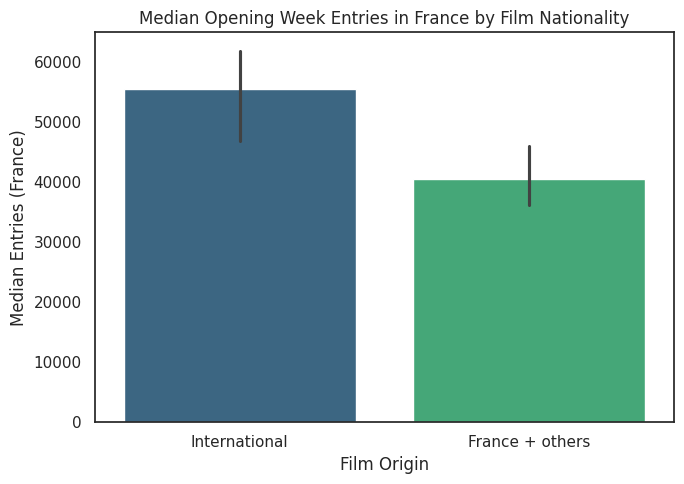

In [29]:
# Filter out empty nationality lists
df_nationality = df_fusion[df_fusion['nationality_list'].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()

# Categorize films
def categorize_film(nat_list):
    if nat_list == ['France']:
        return 'France only'
    elif 'France' in nat_list:
        return 'France + others'
    else:
        return 'International'

df_nationality['film_origin'] = df_nationality['nationality_list'].apply(categorize_film)

# Filter rows with opening week data
df_plot = df_nationality.dropna(subset=['opening_week_france_num'])

plt.figure(figsize=(7, 5))
sns.barplot(data=df_plot, x='film_origin', y='opening_week_france_num', estimator='median', palette='viridis', hue='film_origin', legend=False)
plt.title('Median Opening Week Entries in France by Film Nationality')
plt.ylabel('Median Entries (France)')
plt.xlabel('Film Origin')
plt.tight_layout()
plt.show()

In [30]:
genre_perf

,Genre,Number of Films,Average Opening Week Entries
25,Science Fiction,127,614261.385827
27,Western,7,486507.857143
3,Aventure,472,481183.661017
17,Fantastique,306,470323.444444
14,Espionnage,32,462933.093750
0,Action,536,433553.932836
16,Famille,319,324881.181818
8,Comédie musicale,29,281939.379310
2,Arts Martiaux,30,266168.000000
1,Animation,538,241229.185874


### 🎬 Film Characteristics

#### 🍿 Do shorter or longer movies have better first-week success?

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_28173/1232300880.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df_fusion, x='duration_minutes', y='opening_week_france_num', palette=viridis_colors)


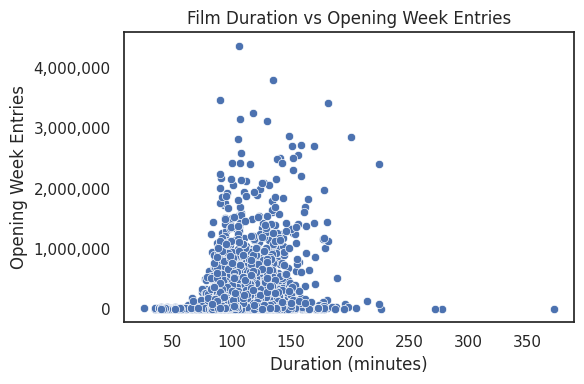

In [31]:
plt.figure(figsize=(6, 4))

sns.scatterplot(data=df_fusion, x='duration_minutes', y='opening_week_france_num', palette=viridis_colors)

plt.title('Film Duration vs Opening Week Entries')
plt.xlabel('Duration (minutes)')
plt.ylabel('Opening Week Entries')

# Format y-axis to show plain numbers (e.g., 500000 instead of 5e5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()
plt.show()

#### 🚸 Do PG, General, or R-rated films tend to get better openings?

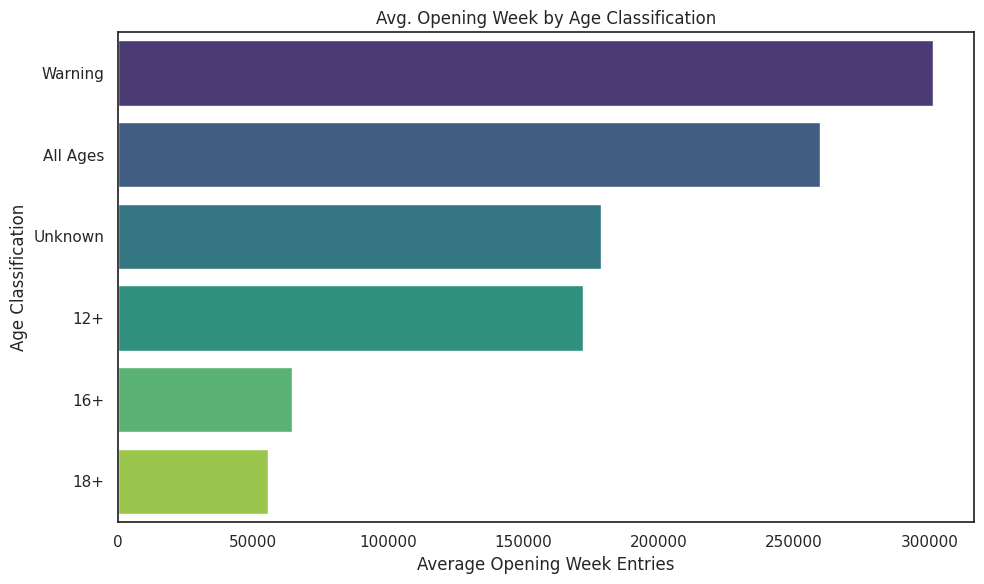

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cleaned/Grouped version for clarity
def simplify_age_classification(age):
    if pd.isnull(age):
        return 'Unknown'
    if '18' in age:
        return '18+'
    elif '16' in age:
        return '16+'
    elif '12' in age:
        return '12+'
    elif 'avertissement' in age.lower():
        return 'Warning'
    elif 'Tout public' in age:
        return 'All Ages'
    else:
        return 'Other'

# Apply simplification
df_fusion['age_class_grouped'] = df_fusion['age_classification'].apply(simplify_age_classification)

# Question 1: Compare average opening for PG vs R-rated-like categories
age_perf = df_fusion.groupby('age_class_grouped')['opening_week_france_num'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)

# Question 2: Plot which age categories dominate top openings
plt.figure(figsize=(10, 6))
sns.barplot(
    data=age_perf.reset_index(), 
    x='mean', 
    y='age_class_grouped', 
    palette='viridis', 
    hue='age_class_grouped',
    legend=False
)
plt.title('Avg. Opening Week by Age Classification')
plt.xlabel('Average Opening Week Entries')
plt.ylabel('Age Classification')
plt.tight_layout()
plt.show()

#### ❄️☃️ How does the release season affect opening_week_france_num?

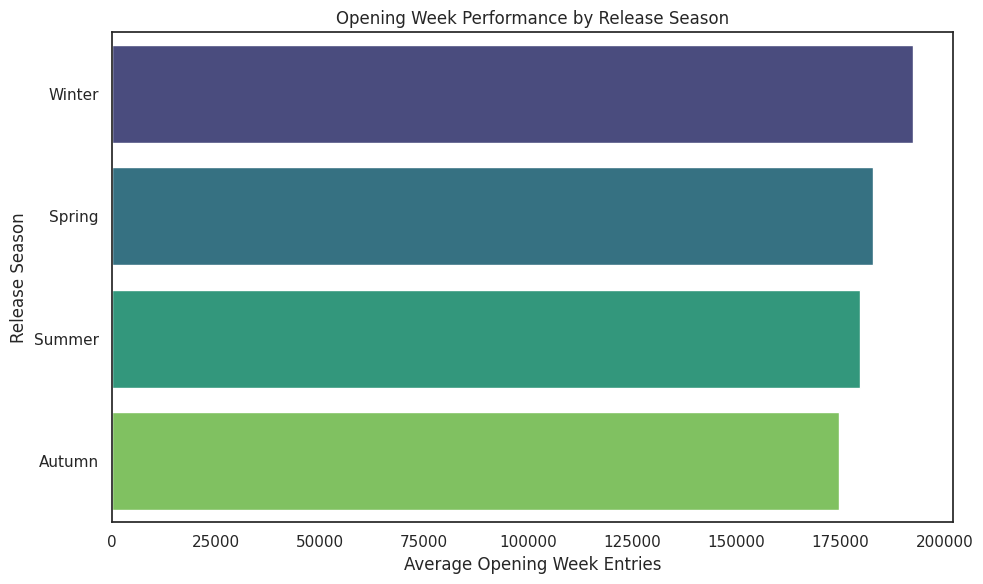

In [33]:
# Group by season and calculate mean opening week performance
season_perf = df_fusion.groupby('release_season')['opening_week_france_num'].agg(['count', 'mean']).sort_values(by='mean', ascending=False)

# Plot the seasons' average opening week performance
plt.figure(figsize=(10, 6))
sns.barplot(data=season_perf.reset_index(), 
            x='mean',  # Access 'mean' column here
            y='release_season', 
            palette='viridis', hue='release_season', legend=False)
plt.title('Opening Week Performance by Release Season')
plt.xlabel('Average Opening Week Entries')
plt.ylabel('Release Season')
plt.tight_layout()
plt.show()

#### 📅 Are certain months consistently better for film debuts?

In [34]:
def int_iso_week_to_month(iso_week_int):
    """Converts an integer ISO week number to a month."""
    if iso_week_int == 0:
        return np.nan  # Or handle it differently, e.g., consider it the last week of the prev year
    try:
        date_str = f'2022-W{iso_week_int:02d}-1'  # Format with leading zero
        month = pd.to_datetime(date_str, format='%G-W%V-%u').month
        return int(month)
    except ValueError:
        return np.nan  # Handle any other potential parsing errors

# Apply the conversion directly to the integer column
df_fusion['fr_entry_month'] = df_fusion['fr_entry_week_iso_week'].apply(int_iso_week_to_month)

# print(df_fusion['fr_entry_month'])

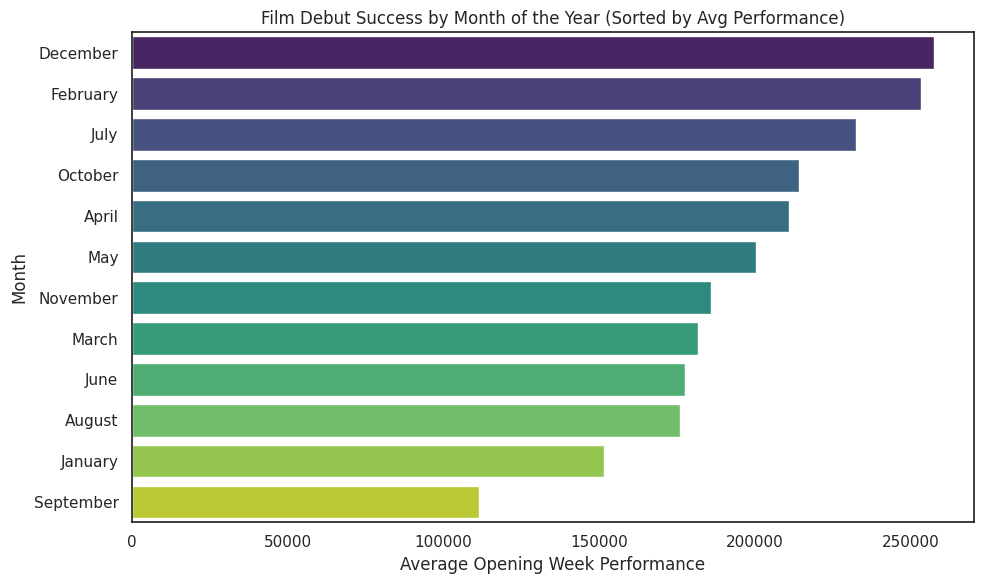

In [35]:
# Map month numbers to actual month names
month_names = {1.0: 'January', 2.0: 'February', 3.0: 'March', 4.0: 'April', 5.0: 'May', 6.0: 'June',
               7.0: 'July', 8.0: 'August', 9.0: 'September', 10.0: 'October', 11.0: 'November', 12.0: 'December'}

# Replace month numbers with month names in the DataFrame
df_fusion['month_name'] = df_fusion['fr_entry_month'].map(month_names)

# Calculate mean performance per month
monthly_performance = df_fusion.groupby('month_name')['opening_week_france_num'].mean()

# Sort by performance (descending) to get most successful debut months on top
monthly_performance = monthly_performance.sort_values(ascending=False)

# Convert to DataFrame for Seaborn
plot_data = pd.DataFrame({
    'Month': monthly_performance.index,
    'Average Performance': monthly_performance.values
})

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Average Performance', y='Month', data=plot_data, palette='viridis', hue='Month', legend=False)

plt.title('Film Debut Success by Month of the Year (Sorted by Avg Performance)')
plt.xlabel('Average Opening Week Performance')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

### 🧑‍🤝‍🧑 Cast, Crew, & Star Power

#### 🎬🌟 Which stars or combinations consistently result in stronger film debuts?

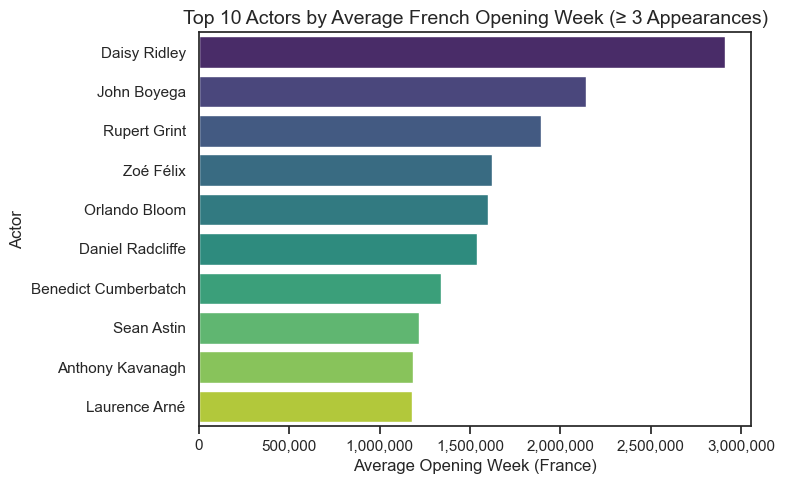

In [36]:
# Function: safely parse stringified list or return the list as-is
def parse_list(x):
    if isinstance(x, list):
        return x
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []

# Apply safe parsing
df_fusion['top_stars_list'] = df_fusion['top_stars_list'].apply(parse_list)

# Explode the list to one actor per row
df_exploded = df_fusion.explode('top_stars_list').rename(columns={'top_stars_list': 'actor'})

# Remove rows with missing opening week or actor
df_exploded = df_exploded.dropna(subset=['opening_week_france_num', 'actor'])

# Group by actor to compute performance
actor_stats = df_exploded.groupby('actor').agg(
    mean_opening_week=('opening_week_france_num', 'mean'),
    appearances=('opening_week_france_num', 'count')
).sort_values(by='mean_opening_week', ascending=False)

# Filter to actors with at least 3 movies
actor_stats_filtered = actor_stats[actor_stats['appearances'] >= 3]

# Select top 10 actors by average opening week
top_actors = actor_stats_filtered.head(10).reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.set(style="white")
sns.barplot(
    data=top_actors,
    x='mean_opening_week',
    y='actor',
    palette='viridis',
    hue='actor',
    legend=False
)


# Format x-axis to show full numbers with commas
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().xaxis.set_major_formatter(formatter)

# Add x-axis tick marks
plt.tick_params(axis='x', which='both', bottom=True, top=False)

plt.title('Top 10 Actors by Average French Opening Week (≥ 3 Appearances)', fontsize=14)
plt.xlabel('Average Opening Week (France)')
plt.ylabel('Actor')
plt.tight_layout()
plt.show()


#### 🎥💼 Which directors have a higher average opening_week_france_num?

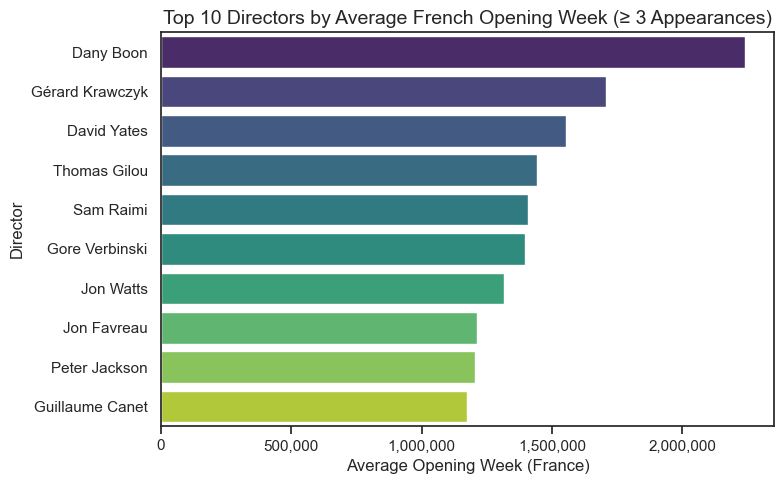

In [37]:
# Remove rows with missing director
df_directors = df_fusion.dropna(subset=['director'])

# Group by director to compute performance
director_stats = df_directors.groupby('director').agg(
    mean_opening_week=('opening_week_france_num', 'mean'),
    appearances=('opening_week_france_num', 'count')
).sort_values(by='mean_opening_week', ascending=False)

# Filter to directors with at least 3 movies
director_stats_filtered = director_stats[director_stats['appearances'] >= 3]

# Select top 10 directors by average opening week
top_directors = director_stats_filtered.head(10).reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.set(style="white")
sns.barplot(
    data=top_directors,
    x='mean_opening_week',
    y='director',
    palette='viridis',
    hue='director',
    legend=False
)


# Format x-axis to show full numbers with commas
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().xaxis.set_major_formatter(formatter)

# Add x-axis tick marks
plt.tick_params(axis='x', which='both', bottom=True, top=False)

plt.title('Top 10 Directors by Average French Opening Week (≥ 3 Appearances)', fontsize=14)
plt.xlabel('Average Opening Week (France)')
plt.ylabel('Director')
plt.tight_layout()
plt.show()


#### 💼📊 Which producers record higher film debuts?

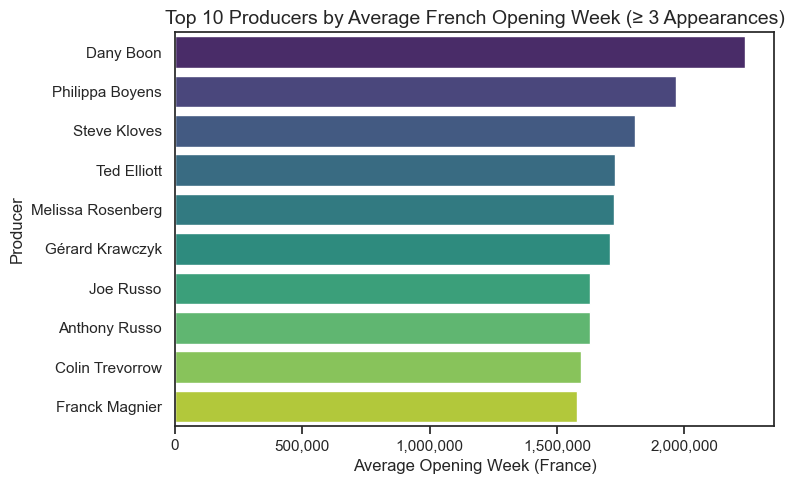

In [38]:
# Apply safe parsing
df_fusion['producers_list'] = df_fusion['producers_list'].apply(parse_list)

# Explode the list to one producer per row
df_exploded = df_fusion.explode('producers_list').rename(columns={'producers_list': 'producer'})

# Remove rows with missing producer
df_exploded = df_exploded.dropna(subset=['producer'])

# Group by producer to compute performance
producer_stats = df_exploded.groupby('producer').agg(
    mean_opening_week=('opening_week_france_num', 'mean'),
    appearances=('opening_week_france_num', 'count')
).sort_values(by='mean_opening_week', ascending=False)

# Filter to producers with at least 3 movies
producer_stats_filtered = producer_stats[producer_stats['appearances'] >= 3]

# Select top 10 prodcuers by average opening week
top_producers = producer_stats_filtered .head(10).reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.set(style="white")
sns.barplot(
    data=top_producers,
    x='mean_opening_week',
    y='producer',
    palette='viridis',
    hue='producer',
    legend=False
)


# Format x-axis to show full numbers with commas
formatter = FuncFormatter(lambda x, _: f'{int(x):,}')
plt.gca().xaxis.set_major_formatter(formatter)

# Add x-axis tick marks
plt.tick_params(axis='x', which='both', bottom=True, top=False)

plt.title('Top 10 Producers by Average French Opening Week (≥ 3 Appearances)', fontsize=14)
plt.xlabel('Average Opening Week (France)')
plt.ylabel('Producer')
plt.tight_layout()
plt.show()


#### 📈🤝 Does having multiple producers (producers_count) correlate with better openings?

Correlation between producers_count and opening_week_france_num: 0.20312655665315732


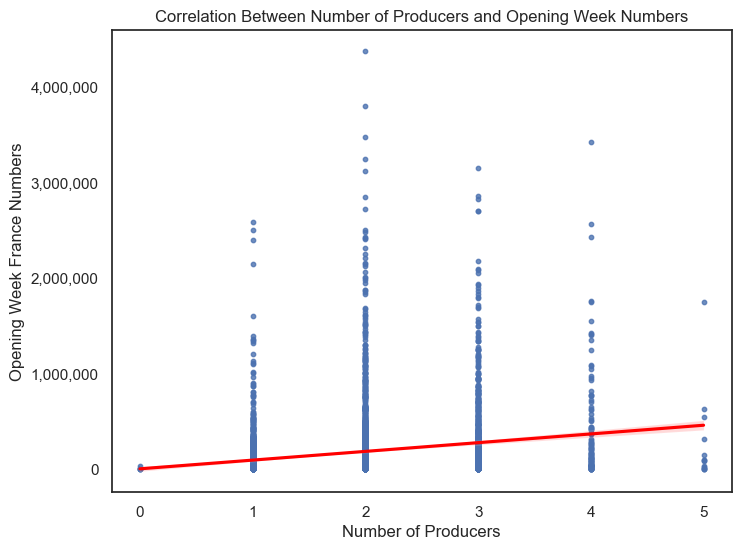

In [39]:
# Calculate the correlation between producers_count and opening_week_france_num
correlation = df_fusion[['producers_count', 'opening_week_france_num']].corr().iloc[0, 1]
print(f"Correlation between producers_count and opening_week_france_num: {correlation}")

# Create a custom formatter to display y-axis numbers in full
def format_yaxis(x, pos):
    return f'{int(x):,}'  # Format the y-axis with commas for thousands

# Visualize the relationship using a scatter plot and a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='producers_count', y='opening_week_france_num', data=df_fusion, scatter_kws={'s': 10}, line_kws={'color': 'red'})

# Apply the custom y-axis formatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))

# Title and labels
plt.title('Correlation Between Number of Producers and Opening Week Numbers')
plt.xlabel('Number of Producers')
plt.ylabel('Opening Week France Numbers')
plt.show()

### 📣 Marketing & Hype

#### 👀 Do higher trailer views translate to better first-week attendance?

Correlation between trailer_views_num and opening_week_france_num: 0.11765453348141665


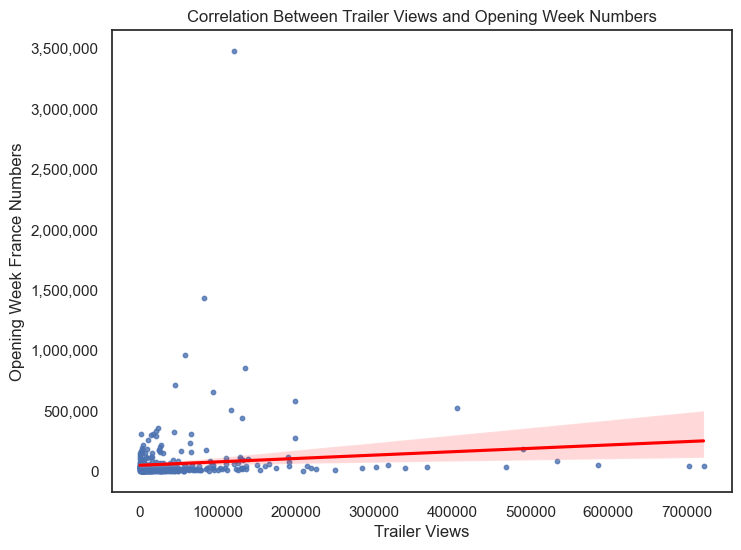

In [40]:
# Calculate the correlation between trailer_views_num and opening_week_france_num
correlation = df_fusion[['trailer_views_num', 'opening_week_france_num']].corr().iloc[0, 1]
print(f"Correlation between trailer_views_num and opening_week_france_num: {correlation}")

# Create a custom formatter to display y-axis numbers in full
def format_yaxis(x, pos):
    return f'{int(x):,}'  # Format the y-axis with commas for thousands

# Visualize the relationship using a scatter plot and a regression line
plt.figure(figsize=(8, 6))
sns.regplot(x='trailer_views_num', y='opening_week_france_num', data=df_fusion, scatter_kws={'s': 10}, line_kws={'color': 'red'})

# Apply the custom y-axis formatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_yaxis))

# Title and labels
plt.title('Correlation Between Trailer Views and Opening Week Numbers')
plt.xlabel('Trailer Views')
plt.ylabel('Opening Week France Numbers')
plt.show()


#### ⭐ Does press rating or viewer rating correlate with higher opening_week_france_num?

                               OLS Regression Results                              
Dep. Variable:     opening_week_france_num   R-squared:                       0.012
Model:                                 OLS   Adj. R-squared:                  0.011
Method:                      Least Squares   F-statistic:                     29.38
Date:                     Tue, 15 Apr 2025   Prob (F-statistic):           2.06e-13
Time:                             10:25:41   Log-Likelihood:                -70439.
No. Observations:                     4977   AIC:                         1.409e+05
Df Residuals:                         4974   BIC:                         1.409e+05
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

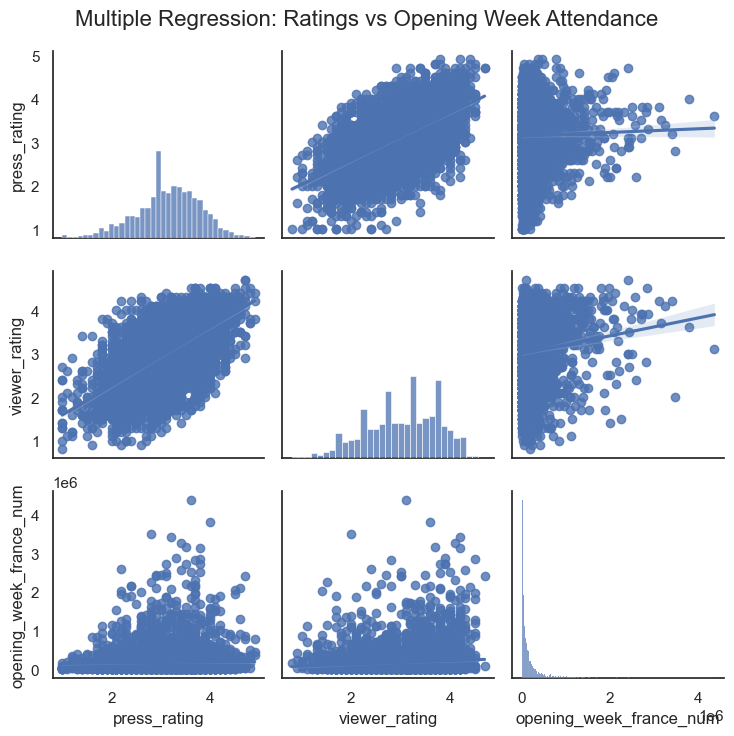

In [41]:
# Prepare the data and remove rows with NaN values
df_filtered = df_fusion[['press_rating', 'viewer_rating', 'opening_week_france_num']].dropna()

X = df_filtered[['press_rating', 'viewer_rating']]  # Features
y = df_filtered['opening_week_france_num']  # Target variable

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

#  Get the model summary
print(model.summary())

# Visualize the regression results
sns.pairplot(df_filtered[['press_rating', 'viewer_rating', 'opening_week_france_num']], kind="reg")
plt.suptitle('Multiple Regression: Ratings vs Opening Week Attendance', size=16)
plt.tight_layout()
plt.show()


#### 📝🔍 What’s the impact of early press and viewer critiques on film debuts?

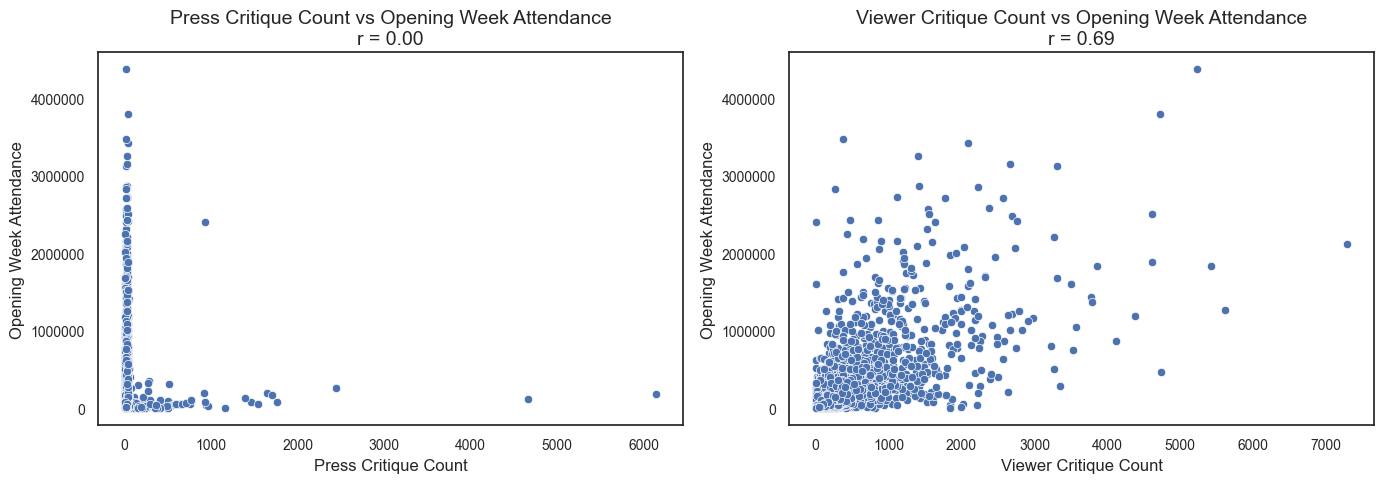

In [42]:
# Filter for non-null values
df_corr = df_fusion[['press_critics_count_num', 'viewer_critiques', 'opening_week_france_num']].dropna()

# Compute correlation coefficients
corr_press, _ = pearsonr(df_corr['press_critics_count_num'], df_corr['opening_week_france_num'])
corr_viewer, _ = pearsonr(df_corr['viewer_critiques'], df_corr['opening_week_france_num'])

# Set up the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Scatter 1: Press rating count vs opening week
sns.scatterplot(data=df_corr, x='press_critics_count_num', y='opening_week_france_num', ax=axs[0])
axs[0].set_title(f'Press Critique Count vs Opening Week Attendance\nr = {corr_press:.2f}')
axs[0].ticklabel_format(style='plain', axis='y')
# Custom x-label with font size
axs[0].set_xlabel("Press Critique Count", fontsize=12)
axs[0].set_ylabel("Opening Week Attendance", fontsize=12)
axs[0].set_title(f'Press Critique Count vs Opening Week Attendance\nr = {corr_press:.2f}', fontsize=14)
axs[0].tick_params(axis='both', labelsize=10)

# Scatter 2: Viewer rating count vs opening week
sns.scatterplot(data=df_corr, x='viewer_critiques', y='opening_week_france_num', ax=axs[1])
axs[1].set_title(f'Viewer Critique Count vs Opening Week Attendance\nr = {corr_viewer:.2f}')
axs[1].ticklabel_format(style='plain', axis='y')
axs[1].set_xlabel("Viewer Critique Count", fontsize=12)
axs[1].set_ylabel("Opening Week Attendance", fontsize=12)
axs[1].set_title(f'Viewer Critique Count vs Opening Week Attendance\nr = {corr_viewer:.2f}', fontsize=14)
axs[1].tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

### 🏆 Prestige & Recognition

#### 🎖️🏅 Do films with awards or nominations perform better during the opening week?

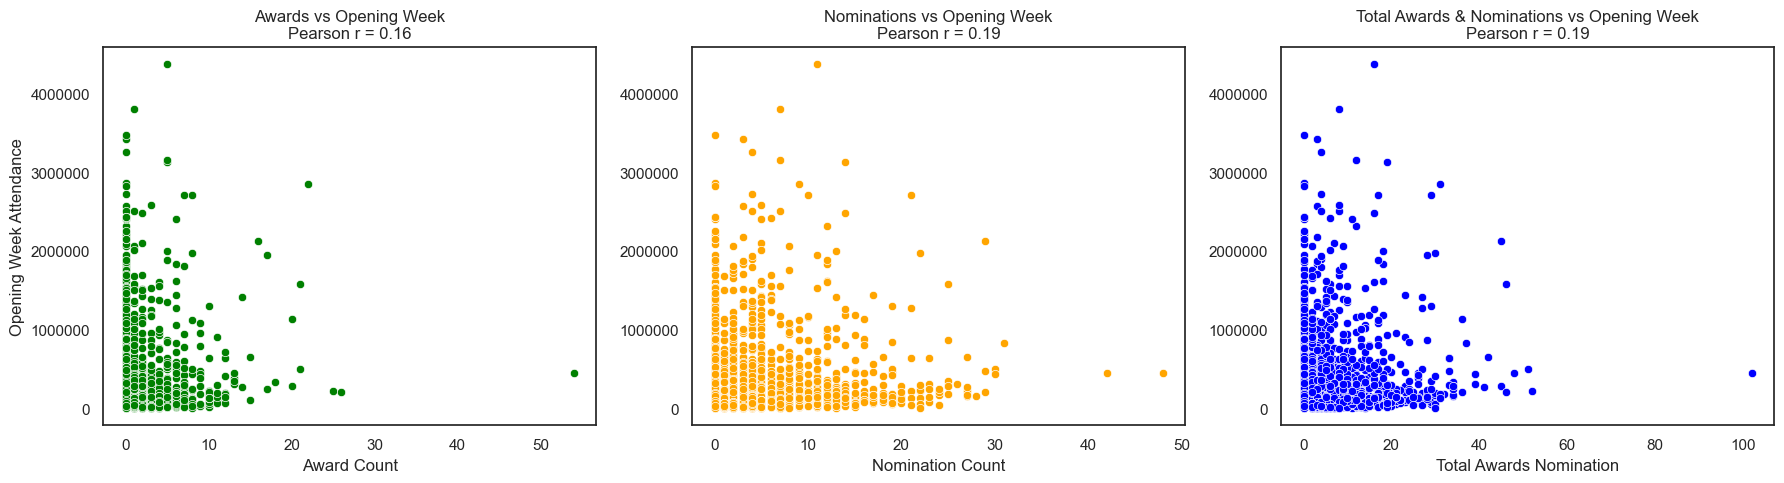

In [ ]:
# Set style
sns.set(style="white")

# Set up the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Data pairs
x_cols = ['award_count', 'nomination_count', 'total_awards_nomination']
titles = [
    'Awards vs Opening Week',
    'Nominations vs Opening Week',
    'Total Awards & Nominations vs Opening Week'
]
colors = ['green', 'orange', 'blue']

for i, (x_col, title, color) in enumerate(zip(x_cols, titles, colors)):
    sns.scatterplot(
        data=df_fusion,
        x=x_col,
        y='opening_week_france_num',
        ax=axs[i],
        color=color
    )
    
    # Calculate correlation coefficient
    valid_data = df_fusion[[x_col, 'opening_week_france_num']].dropna()
    corr, _ = pearsonr(valid_data[x_col], valid_data['opening_week_france_num'])

    axs[i].set_title(f"{title}\nPearson r = {corr:.2f}")
    axs[i].set_xlabel(x_col.replace('_', ' ').title())
    axs[i].set_ylabel('Opening Week Attendance' if i == 0 else '')
    axs[i].ticklabel_format(style='plain', axis='y')

# Adjust layout
plt.tight_layout()
plt.show()

### 💰 Budget & Revenue

#### 💵 Do films with higher budget have better opening week success? 

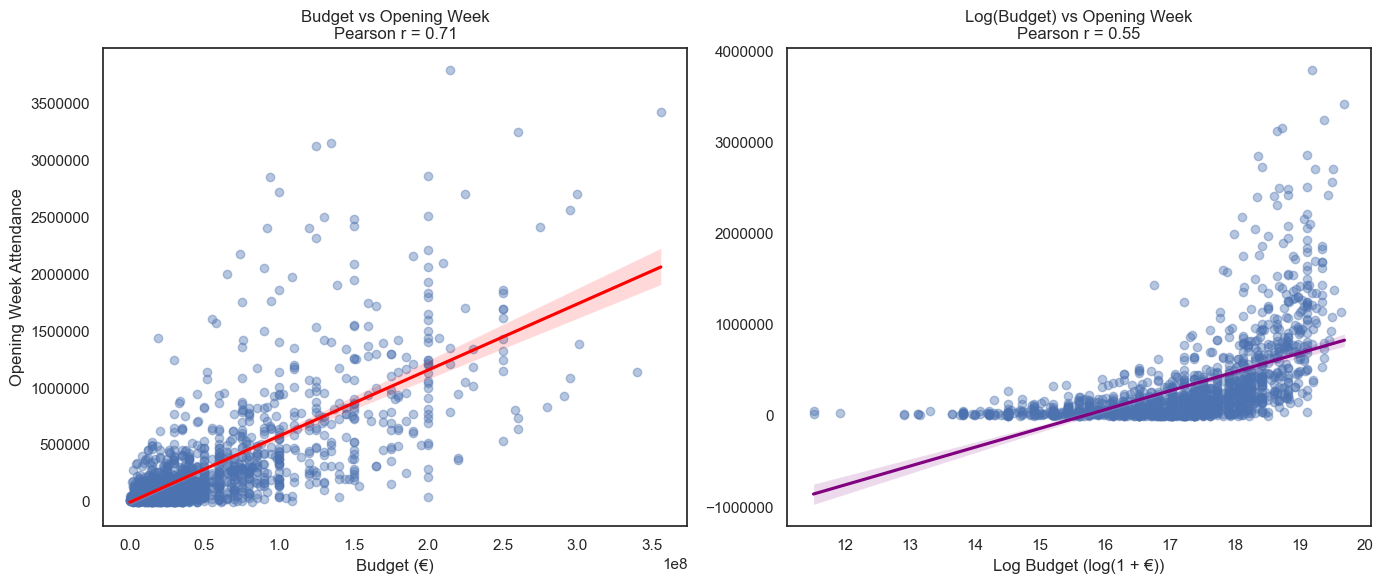

In [76]:
# Set style
sns.set(style="white")

# Set up subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Budget vs Opening Week Success
x1, y1 = df_fusion['budget'], df_fusion['opening_week_france_num']
sns.regplot(x=x1, y=y1, ax=axs[0], scatter_kws={'alpha': 0.4}, line_kws={"color": "red"})
corr1, _ = pearsonr(x1.dropna(), y1.loc[x1.notna()])
axs[0].set_title(f"Budget vs Opening Week\nPearson r = {corr1:.2f}")
axs[0].set_xlabel("Budget (€)")
axs[0].set_ylabel("Opening Week Attendance")
axs[0].ticklabel_format(style='plain', axis='y')

# Plot 2: Log-Scaled Budget to see diminishing returns
x2 = df_fusion['budget']
y2 = df_fusion['opening_week_france_num']
sns.regplot(x=np.log1p(x2), y=y2, ax=axs[1], scatter_kws={'alpha': 0.4}, line_kws={"color": "purple"})
corr2, _ = pearsonr(np.log1p(x2.dropna()), y2.loc[x2.notna()])
axs[1].set_title(f"Log(Budget) vs Opening Week\nPearson r = {corr2:.2f}")
axs[1].set_xlabel("Log Budget (log(1 + €))")
axs[1].set_ylabel("")
axs[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()


### 📅 Release Strategy

#### 🌍🇺🇸📅 Does releasing earlier in the USA (release_date_usa) or simultaneously affect first-week performance in France?

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_28173/2959918580.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_fusion, x='release_timing_category', y='opening_week_france_num', palette="Set2")


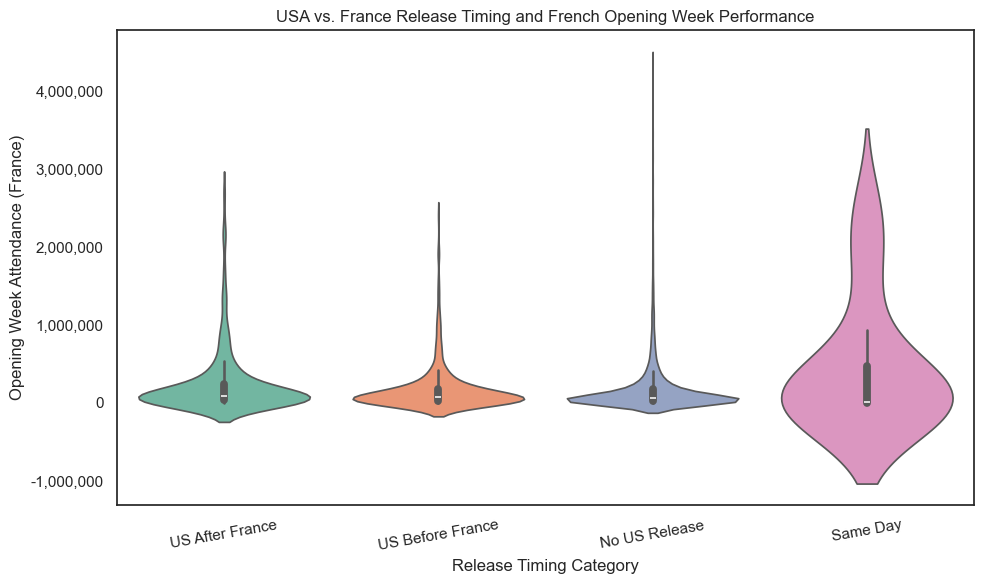

In [ ]:
# Calculate the delay (positive: US after France, negative: US before France)
df_fusion['release_diff'] = (df_fusion['release_date_usa'] - df_fusion['release_date_france']).dt.days

# Categorize release timing
def categorize_timing(diff):
    if pd.isna(diff):
        return "No US Release"
    elif diff < 0:
        return "US Before France"
    elif diff == 0:
        return "Same Day"
    else:
        return "US After France"

df_fusion['release_timing_category'] = df_fusion['release_diff'].apply(categorize_timing)

# Plot with a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_fusion, x='release_timing_category', y='opening_week_france_num', palette="Set2")
plt.title("USA vs. France Release Timing and French Opening Week Performance")
plt.xlabel("Release Timing Category")
plt.ylabel("Opening Week Attendance (France)")
plt.xticks(rotation=10)

# Apply the custom y-axis formatting
plt.gca().yaxis.set_major_formatter(FuncFormatter(formatter))

plt.tight_layout()
plt.show()

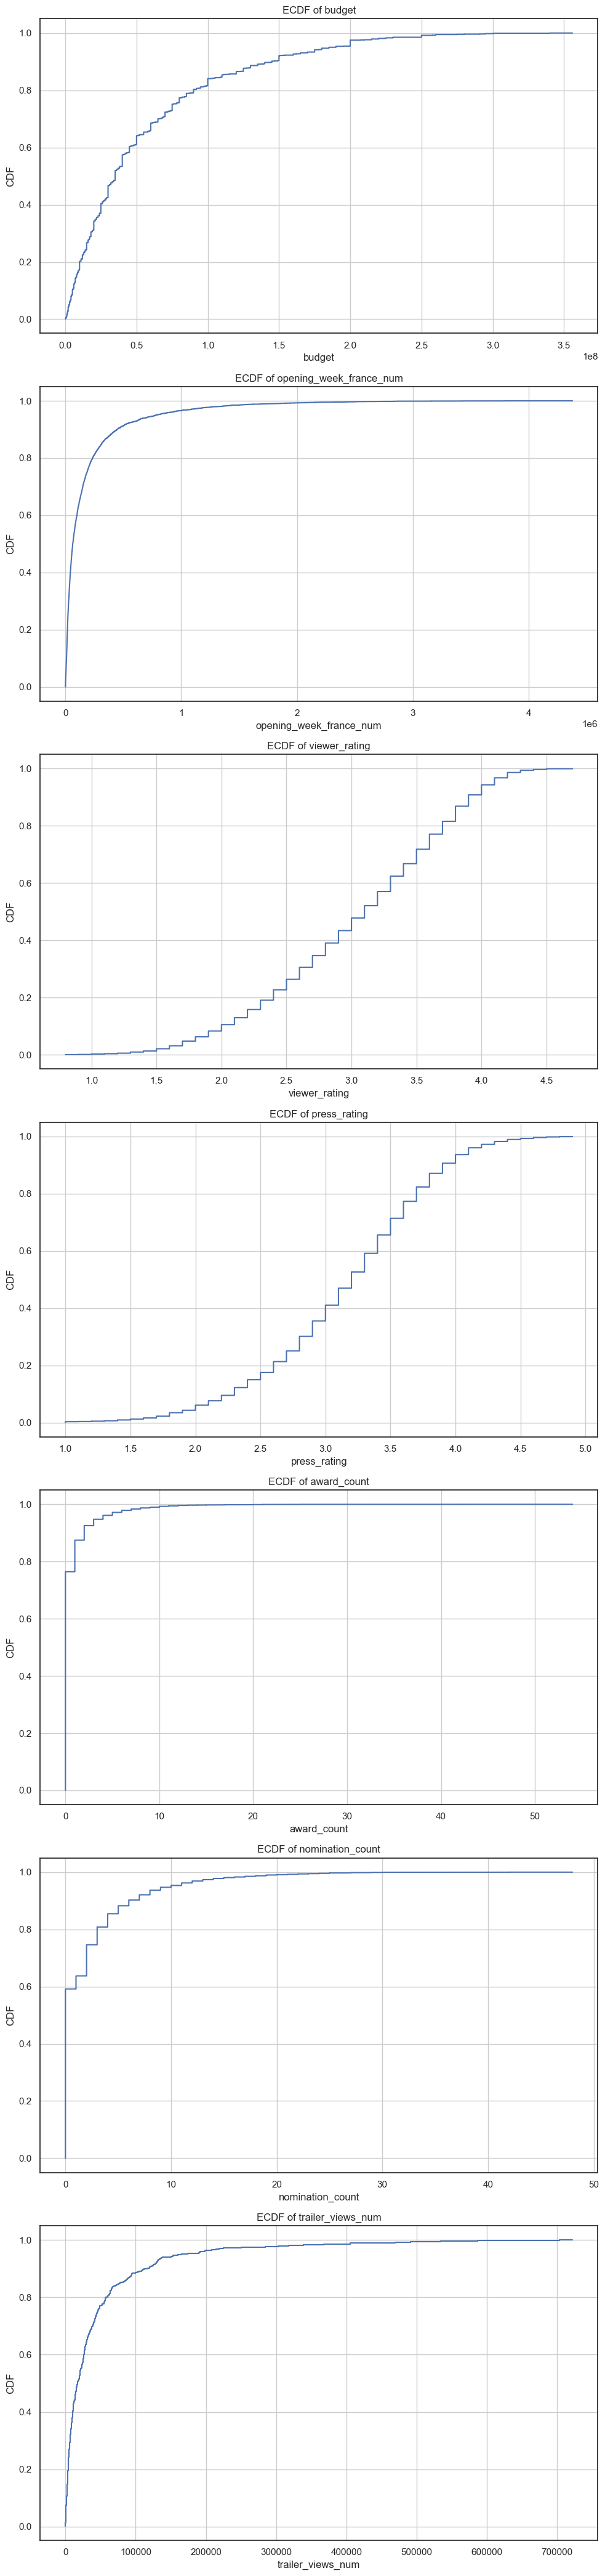

In [79]:
# List of columns for which ECDF plots will be created (excluding fr_entries)
columns_to_plot = [
    'budget', 
    'opening_week_france_num', 
    'viewer_rating', 
    'press_rating', 
    'award_count', 
    'nomination_count', 
    'trailer_views_num'
]

# Create a figure with multiple subplots (one for each column)
fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(10, 6 * len(columns_to_plot)))

# Loop through the columns and plot the ECDF for each
for i, col in enumerate(columns_to_plot):
    # Drop NaN values before plotting
    data = df_fusion[col].dropna()
    
    # Calculate ECDF using the sorted values
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Plot ECDF
    axs[i].step(sorted_data, yvals, label=f'{col} ECDF')
    axs[i].set_title(f'ECDF of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('CDF')
    axs[i].grid(True)

# Adjust the layout
plt.tight_layout()
plt.show()


### 📝 Text Analysis Opportunities

#### 📖📊 Does positive sentiment in the synopsis or synopsis_length correlate with more first-week entries?

Correlation between synopsis sentiment and entries: -0.0022564377093350838
Correlation between synopsis length and opening week attendance: 0.06602708565220042


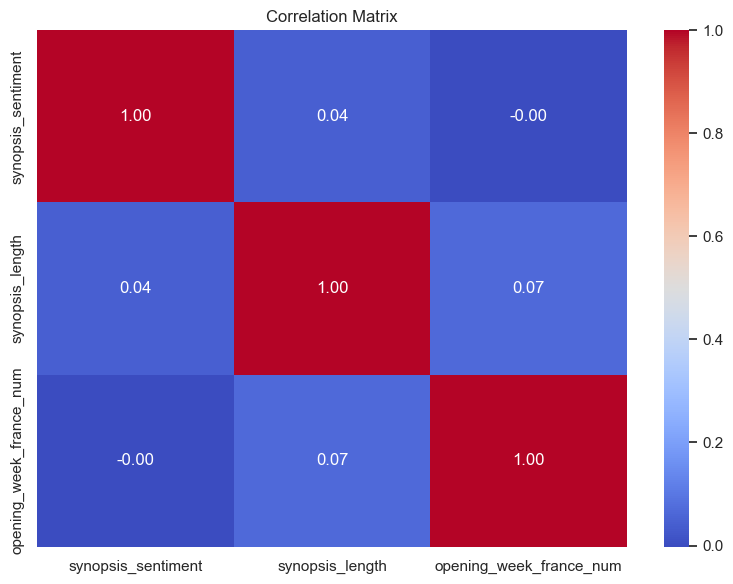

In [ ]:
# Check if positive sentiment correlates with more entries (fr_entries)
correlation_sentiment_entries = df_fusion['synopsis_sentiment'].corr(df_fusion['opening_week_france_num'])

# Check if longer synopses correlate with first-week attendance (opening_week_france_num)
correlation_synopsis_length_performance = df_fusion['synopsis_length'].corr(df_fusion['opening_week_france_num'])

# Print correlation results
print(f"Correlation between synopsis sentiment and opening week attendance: {correlation_sentiment_entries}")
print(f"Correlation between synopsis length and opening week attendance: {correlation_synopsis_length_performance}")

# Visualize the correlation matrix
correlation_matrix = df_fusion[['synopsis_sentiment', 'synopsis_length', 'opening_week_france_num']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

#### 🎬💥 Does the presence of "filming secrets" content reflect marketing hype that drives openings?

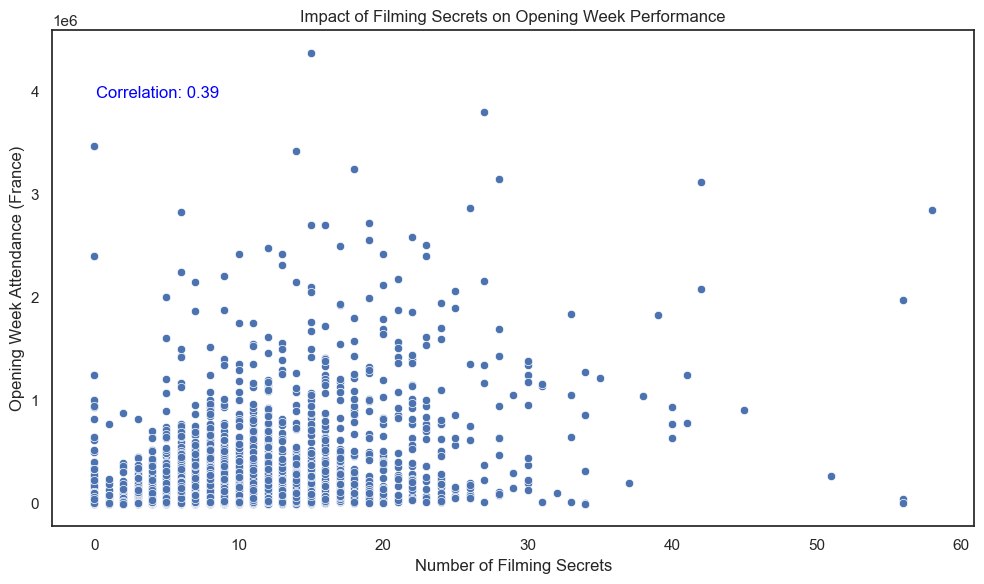

Correlation between filming secrets and opening week attendance: 0.39


In [90]:
# Calculate the correlation coefficient
correlation = df_fusion['filming_secrets_num'].corr(df_fusion['opening_week_france_num'])

# Plotting the correlation between filming_secrets_num and opening_week_france_num
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_fusion, x='filming_secrets_num', y='opening_week_france_num')
plt.title("Impact of Filming Secrets on Opening Week Performance")
plt.xlabel("Number of Filming Secrets")
plt.ylabel("Opening Week Attendance (France)")

# Add the correlation coefficient to the plot
plt.text(x=0.1, y=max(df_fusion['opening_week_france_num']) * 0.9, 
         s=f'Correlation: {correlation:.2f}', fontsize=12, color='blue')

plt.tight_layout()
plt.show()

# Print the correlation coefficient
print(f"Correlation between filming secrets and opening week attendance: {correlation:.2f}")

### 🔁 Engagement & Longevity

#### 🎭 How has viewers' first-week attendance evolved based on genre preference between 2000 - 2024 ? 

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_28173/2822900874.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_fusion['opening_week_france_num'].fillna(0, inplace=True)


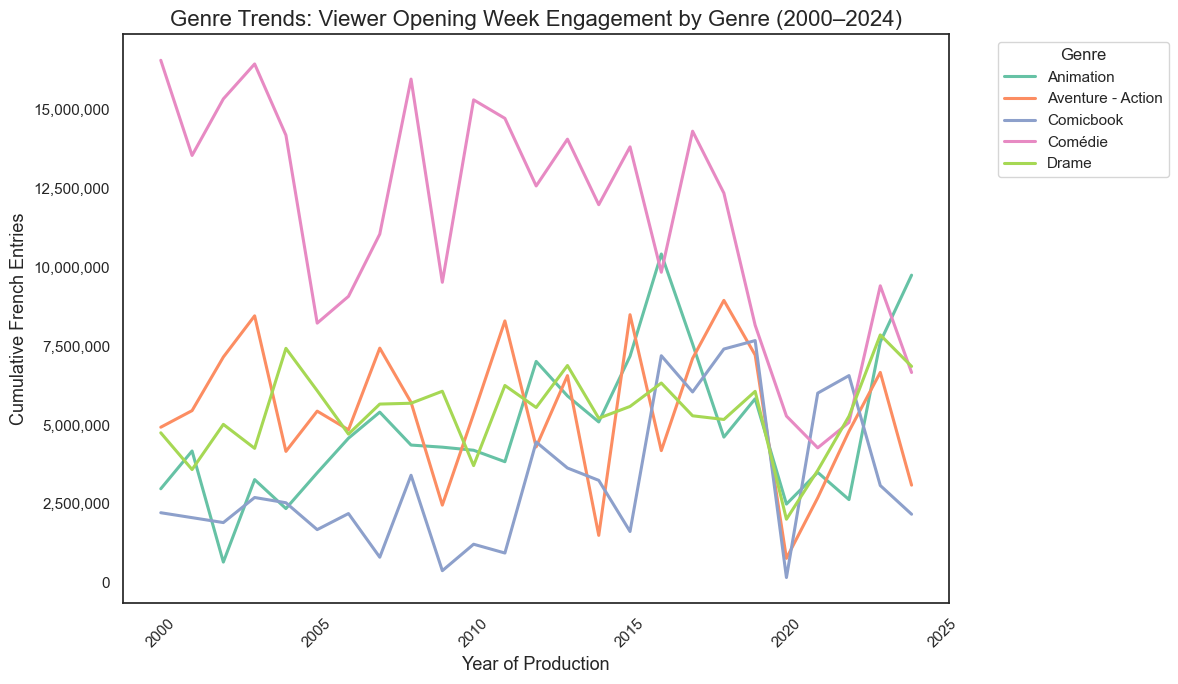

In [101]:
# Clean and convert 'fr_entries_cumul' to numeric
df_fusion['opening_week_france_num'].fillna(0, inplace=True)

# Filter years between 2000 and 2024
df_filtered = df_fusion[(df_fusion['year_of_production'] >= 2000) & (df_fusion['year_of_production'] <= 2024)]

# Group by year and genre
grouped = df_filtered.groupby(['year_of_production', 'main_genre_jpboxoffice'])['opening_week_france_num'].sum().reset_index()

# Find top 5 genres with highest total cumulative entries
top_genres = grouped.groupby('main_genre_jpboxoffice')['opening_week_france_num'].sum().nlargest(5).index

# Filter only top 5 genres
grouped_top5 = grouped[grouped['main_genre_jpboxoffice'].isin(top_genres)]

# Plot
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=grouped_top5, 
    x='year_of_production', 
    y='opening_week_france_num', 
    hue='main_genre_jpboxoffice',
   # marker="o",
    linewidth=2.2,
    palette="Set2"
)

plt.title("Genre Trends: Viewer Opening Week Engagement by Genre (2000–2024)", fontsize=16)
plt.xlabel("Year of Production", fontsize=13)
plt.ylabel("Cumulative French Entries", fontsize=13)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

#### 🎭 How has viewer' cummulative attendance evolved based on genre preference between 2000 - 2024 ? 

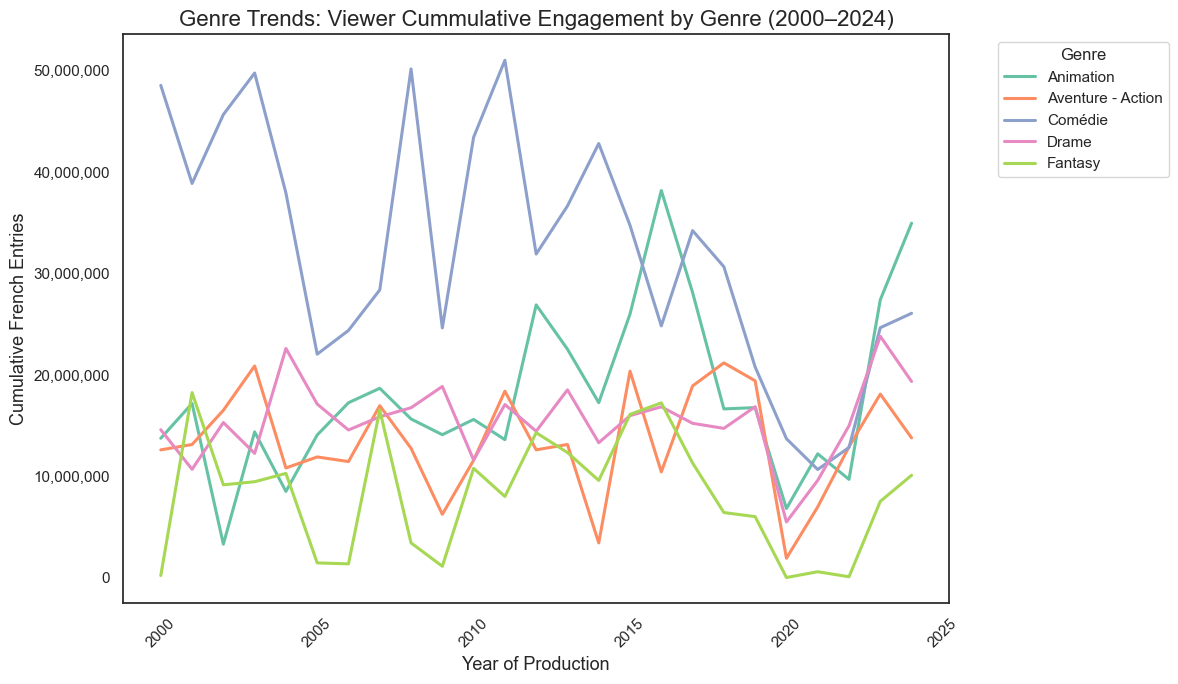

In [100]:
# Clean and convert 'fr_entries_cumul' to numeric
df_fusion['fr_entries_cumul'].fillna(0, inplace=True)

# Filter years between 2000 and 2024
df_filtered = df_fusion[(df_fusion['year_of_production'] >= 2000) & (df_fusion['year_of_production'] <= 2024)]

# Group by year and genre
grouped = df_filtered.groupby(['year_of_production', 'main_genre_jpboxoffice'])['fr_entries_cumul'].sum().reset_index()

# Find top 5 genres with highest total cumulative entries
top_genres = grouped.groupby('main_genre_jpboxoffice')['fr_entries_cumul'].sum().nlargest(5).index

# Filter only top 5 genres
grouped_top5 = grouped[grouped['main_genre_jpboxoffice'].isin(top_genres)]

# Plot
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=grouped_top5, 
    x='year_of_production', 
    y='fr_entries_cumul', 
    hue='main_genre_jpboxoffice',
   # marker="o",
    linewidth=2.2,
    palette="Set2"
)

plt.title("Genre Trends: Viewer Cummulative Engagement by Genre (2000–2024)", fontsize=16)
plt.xlabel("Year of Production", fontsize=13)
plt.ylabel("Cumulative French Entries", fontsize=13)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### 🧩 Other Analysis

##### Correlation Analysis

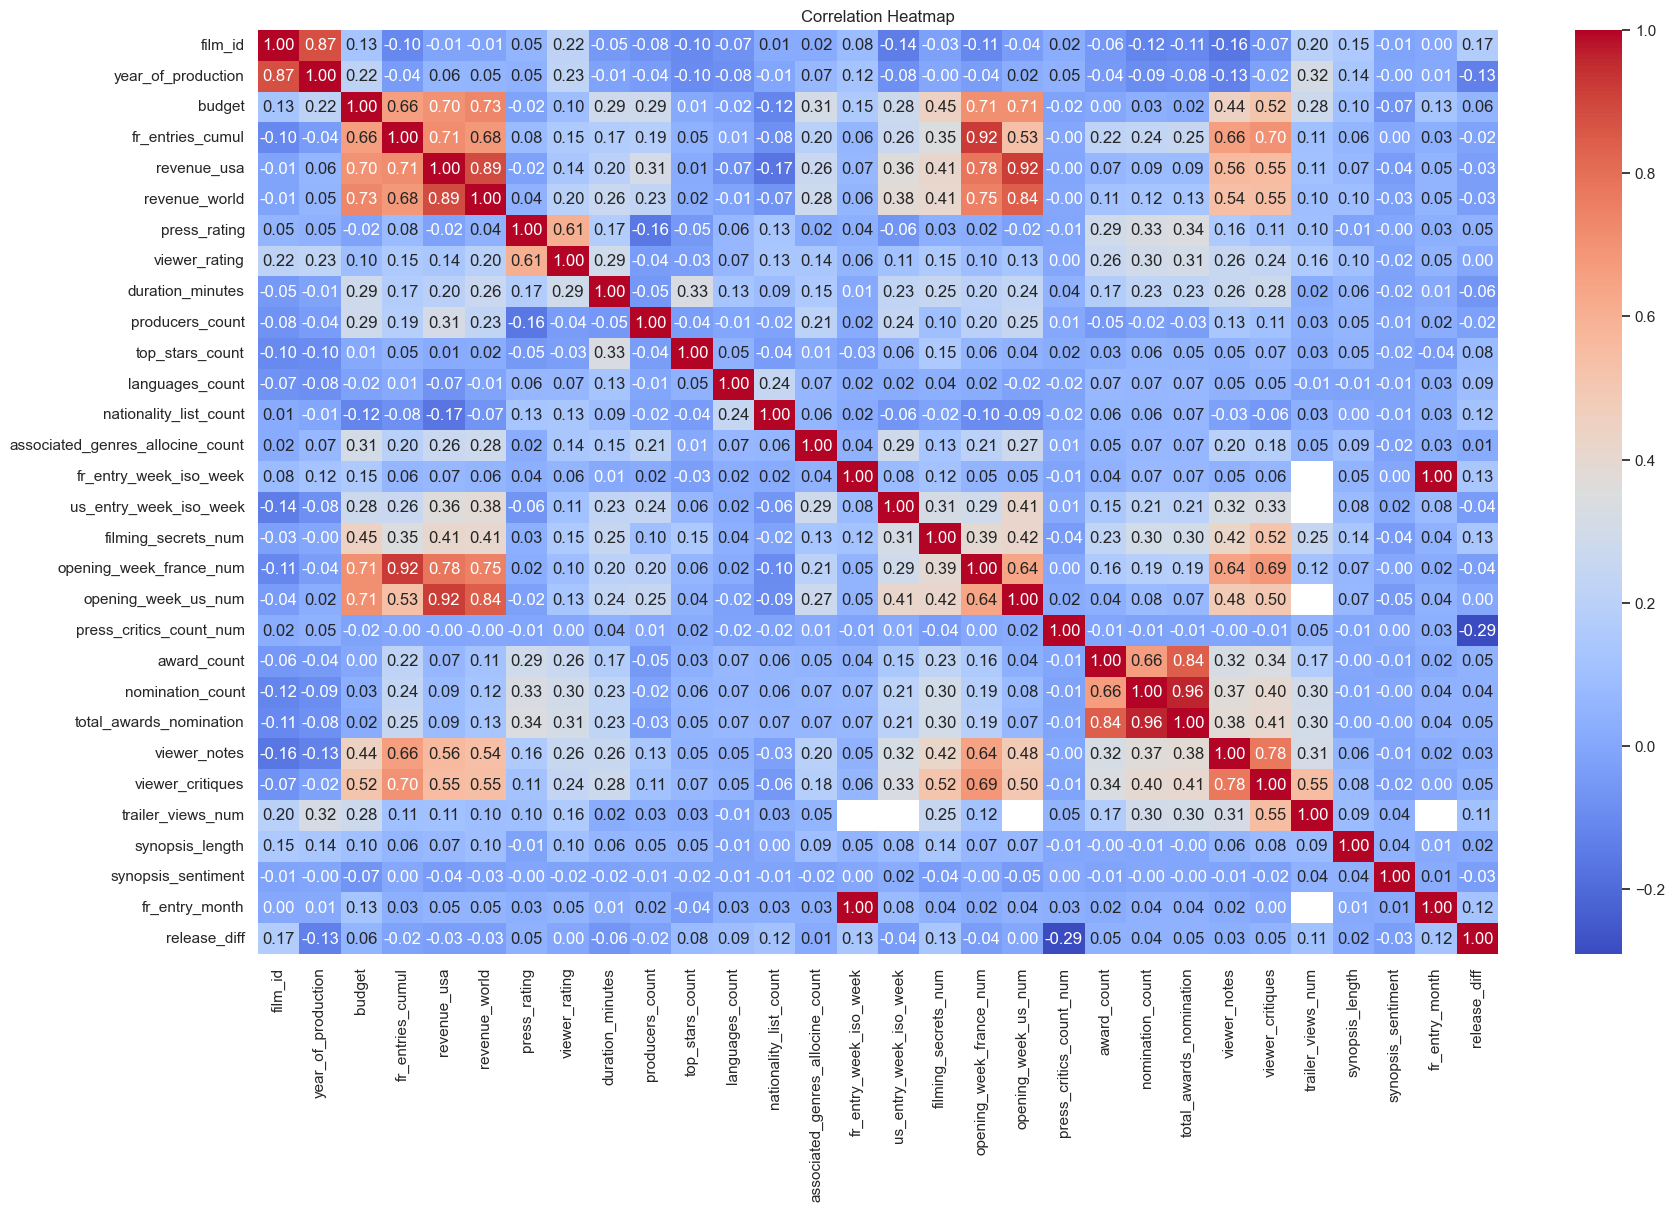

In [102]:
def correlation_matrix(df):
    numeric_cols = df.select_dtypes(include=np.number)
    corr = numeric_cols.corr()
    plt.figure(figsize=(20, 12))
    sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

correlation_matrix(df_fusion)

#### Number of Entries based on genre performance and viewer rating evolution over time

In [43]:
def genre_performance(df):
    genre_perf = (
        df.groupby('main_genre_jpboxoffice')[['opening_week_france_num', 'viewer_rating']]
        .mean()
        .sort_values(by='opening_week_france_num', ascending=False)
        .reset_index()
    )
    return genre_perf

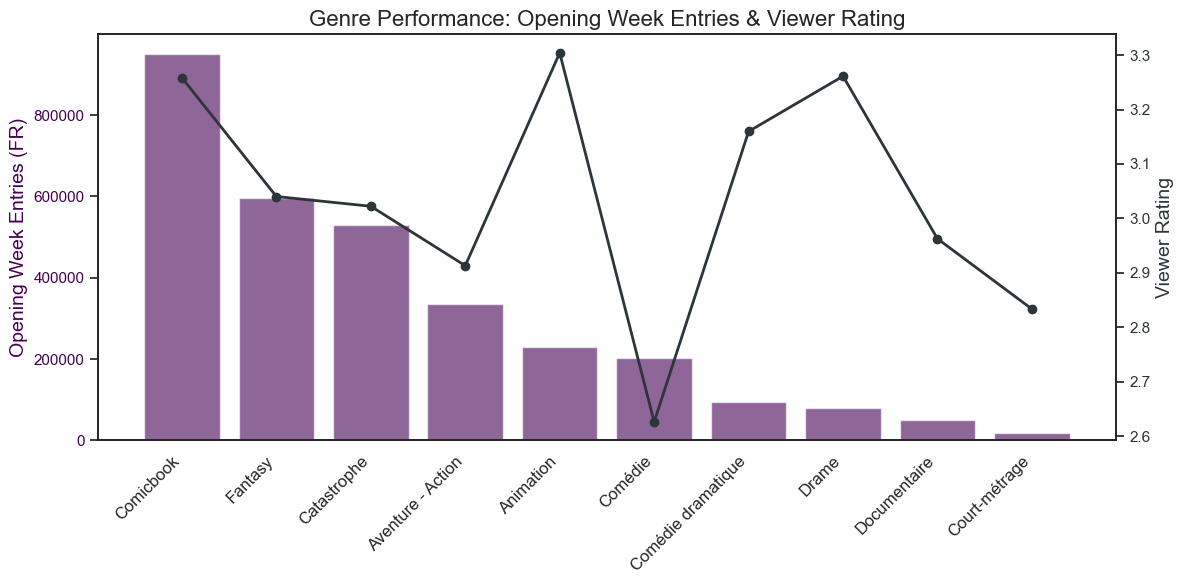

In [131]:
def plot_genre_performance_dual_axis(genre_perf_df):
    df_sorted = genre_perf_df.sort_values(by='opening_week_france_num', ascending=False)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    genres = df_sorted['main_genre_jpboxoffice']
    x = np.arange(len(genres))

    color1 = 'tab:blue'
    ax1.bar(x, df_sorted['opening_week_france_num'], color=viridis_colors[0], alpha=0.6, label='Opening Week Entries')
    ax1.set_ylabel('Opening Week Entries (FR)', color=viridis_colors[0], fontsize=14)
    ax1.set_xticks(x)
    ax1.set_xticklabels(genres, rotation=45, ha='right', fontsize=12)
    ax1.tick_params(axis='y', labelcolor=viridis_colors[0])

    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.plot(x, df_sorted['viewer_rating'], color='#2C3539', marker='o', linewidth=2, label='Viewer Rating')
    ax2.set_ylabel('Viewer Rating', color='#2C3539', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='#2C3539')

    plt.title('Genre Performance: Opening Week Entries & Viewer Rating', fontsize=16)
    fig.tight_layout()
    plt.show()


genre_perf_df = genre_performance(df_fusion)
plot_genre_performance_dual_axis(genre_perf_df)

### 